In [2]:
import pandas as pd
import numpy as np
from datetime import date
import datetime as dt
import os

In [3]:
#1754884 record,1053282 with coupon_id,9738 coupon. date_received:20160101~20160615,date:20160101~20160630, 539438 users, 8415 merchants
off_train = pd.read_csv('ccf_o2o_tianchi/ccf_offline_stage1_train.csv', header=0,keep_default_na=False)
off_train.columns = ['user_id','merchant_id','coupon_id','discount_rate','distance','date_received','date']
#2050 coupon_id. date_received:20160701~20160731, 76309 users(76307 in trainset, 35965 in online_trainset), 1559 merchants(1558 in trainset)
off_test = pd.read_csv('ccf_o2o_tianchi/ccf_offline_stage1_test_revised.csv',header=0,keep_default_na=False)
off_test.columns = ['user_id','merchant_id','coupon_id','discount_rate','distance','date_received']
# #11429826 record(872357 with coupon_id),762858 user(267448 in off_train)
# on_train = pd.read_csv('ccf_o2o_tianchi/ccf_online_stage1_train.csv',header=None)
# on_train.columns = ['user_id','merchant_id','action','coupon_id','discount_rate','date_received','date']
off_train.head()


user_id  merchant_id coupon_id discount_rate distance date_received  \
0  1439408         2632      null          null        0          null   
1  1439408         4663     11002        150:20        1      20160528   
2  1439408         2632      8591          20:1        0      20160217   
3  1439408         2632      1078          20:1        0      20160319   
4  1439408         2632      8591          20:1        0      20160613   

       date  
0  20160217  
1      null  
2      null  
3      null  
4      null

In [4]:
off_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754884 entries, 0 to 1754883
Data columns (total 7 columns):
user_id          int64
merchant_id      int64
coupon_id        object
discount_rate    object
distance         object
date_received    object
date             object
dtypes: int64(2), object(5)
memory usage: 93.7+ MB


In [5]:
#交叉训练集一：收到券的日期大于4月14日和小于5月14日
dataset1 = off_train[(off_train.date_received>='201604014')&(off_train.date_received<='20160514')]
#交叉训练集一特征：线下数据中领券和用券日期大于1月1日和小于4月13日
feature1 = off_train[(off_train.date>='20160101')&(off_train.date<='20160413')|((off_train.date=='null')&(off_train.date_received>='20160101')&(off_train.date_received<='20160413'))]

#交叉训练集二：收到券的日期大于5月15日和小于6月15日
dataset2 = off_train[(off_train.date_received>='20160515')&(off_train.date_received<='20160615')]
#交叉训练集二特征：线下数据中领券和用券日期大于2月1日和小于5月14日
feature2 = off_train[(off_train.date>='20160201')&(off_train.date<='20160514')|((off_train.date=='null')&(off_train.date_received>='20160201')&(off_train.date_received<='20160514'))]

#测试集
dataset3 = off_test
#测试集特征 :线下数据中领券和用券日期大于3月15日和小于6月30日的
feature3 = off_train[((off_train.date>='20160315')&(off_train.date<='20160630'))|((off_train.date=='null')&(off_train.date_received>='20160315')&(off_train.date_received<='20160630'))]

In [6]:
def is_firstlastone(x):
    if x==0:
        return 1
    elif x>0:
        return 0
    else:
        return -1

def get_day_gap_before(s):
    date_received,dates = s.split('-')
    dates = dates.split(':')
    gaps = []
    for d in dates:
        #将时间差转化为天数
        this_gap = (dt.date(int(date_received[0:4]),int(date_received[4:6]),int(date_received[6:8]))-dt.date(int(d[0:4]),int(d[4:6]),int(d[6:8]))).days
        if this_gap>0:
            gaps.append(this_gap)
    if len(gaps)==0:
        return -1
    else:
        return min(gaps)
def get_day_gap_after(s):
    date_received,dates = s.split('-')
    dates = dates.split(':')
    gaps = []
    for d in dates:
        this_gap = (dt.datetime(int(d[0:4]),int(d[4:6]),int(d[6:8]))-dt.datetime(int(date_received[0:4]),int(date_received[4:6]),int(date_received[6:8]))).days
        if this_gap>0:
            gaps.append(this_gap)
    if len(gaps)==0:
        return -1
    else:
        return min(gaps)

def GetOtherFeature(dataset):
    t = dataset[['user_id']].copy()
    t['this_month_user_receive_all_coupon_count'] = 1
    t = t.groupby('user_id').agg('sum').reset_index()
    
    t1 = dataset[['user_id','coupon_id']].copy()
    t1['this_month_user_receive_same_coupn_count'] = 1
    t1 = t1.groupby(['user_id','coupon_id']).agg('sum').reset_index()
    
    t2 = dataset[['user_id','coupon_id','date_received']].copy()
    t2.date_received = t2.date_received.astype('str')
    #如果出现相同的用户接收相同的优惠券在接收时间上用‘：’连接上第n次接受优惠券的时间
    t2 = t2.groupby(['user_id','coupon_id'])['date_received'].agg(lambda x:':'.join(x)).reset_index()
    #将接收时间的一组按着':'分开，这样就可以计算接受了优惠券的数量,apply是合并
    t2['receive_number'] = t2.date_received.apply(lambda s:len(s.split(':')))
    t2 = t2[t2.receive_number > 1]
    #最大接受的日期
  
    t2['max_date_received'] = t2.date_received.apply(lambda s:max([int(d) for d in s.split(':')]))
    #最小的接收日期
    t2['min_date_received'] = t2.date_received.apply(lambda s:min([int(d) for d in s.split(':')]))
    t2 = t2[['user_id','coupon_id','max_date_received','min_date_received']]

    t3 = dataset[['user_id','coupon_id','date_received']]
    #将两表融合只保留左表数据,这样得到的表，相当于保留了最近接收时间和最远接受时间
    t3 = pd.merge(t3,t2,on=['user_id','coupon_id'],how='left')
    #这个优惠券最近接受时间
    t3['this_month_user_receive_same_coupon_lastone']= t3.max_date_received-t3.date_received.astype(int)
    #这个优惠券最远接受时间
    t3['this_month_user_receive_same_coupon_firstone'] = t3.date_received.astype(int)-t3.min_date_received
    
    t3.this_month_user_receive_same_coupon_lastone = t3.this_month_user_receive_same_coupon_lastone.apply(is_firstlastone)
    t3.this_month_user_receive_same_coupon_firstone = t3.this_month_user_receive_same_coupon_lastone.apply(is_firstlastone)
    t3 = t3[['user_id','coupon_id','date_received','this_month_user_receive_same_coupon_lastone','this_month_user_receive_same_coupon_firstone']]
       
    #提取第四个特征,一个用户所接收到的所有优惠券的数量
    t4 = dataset[['user_id','date_received']].copy()
    t4['this_day_receive_all_coupon_count'] = 1
    t4 = t4.groupby(['user_id','date_received']).agg('sum').reset_index()

    #提取第五个特征,一个用户不同时间所接收到不同优惠券的数量
    t5 = dataset[['user_id','coupon_id','date_received']].copy()
    t5['this_day_user_receive_same_coupon_count'] = 1
    t5 = t5.groupby(['user_id','coupon_id','date_received']).agg('sum').reset_index()
    #一个用户不同优惠券 的接受时间
    t6 = dataset[['user_id','coupon_id','date_received']].copy()
    t6.date_received = t6.date_received.astype('str')
    t6 = t6.groupby(['user_id','coupon_id'])['date_received'].agg(lambda x:':'.join(x)).reset_index()
    t6.rename(columns={'date_received':'dates'},inplace = True)
    
    t7 = dataset[['user_id','coupon_id','date_received']]
    t7 = pd.merge(t7,t6,on=['user_id','coupon_id'],how='left')
    t7['date_received_date'] = t7.date_received.astype('str')+'-'+t7.dates
    t7['day_gap_before'] = t7.date_received_date.apply(get_day_gap_before)
    t7['day_gap_after'] = t7.date_received_date.apply(get_day_gap_after)
    t7 = t7[['user_id','coupon_id','date_received','day_gap_before','day_gap_after']]
    
    other_feature = pd.merge(t1,t,on='user_id')
    other_feature = pd.merge(other_feature,t3,on=['user_id','coupon_id'])
    other_feature = pd.merge(other_feature,t4,on=['user_id','date_received'])
    other_feature = pd.merge(other_feature,t5,on=['user_id','coupon_id','date_received'])
    other_feature = pd.merge(other_feature,t7,on=['user_id','coupon_id','date_received'])
    return other_feature

In [7]:
def calc_discount_rate(s):
    s = str(s)
    s = s.split(':')
    if len(s) == 1:
        return float(s[0])
    else:
        return 1.0-float(s[1])/float(s[0])
def get_discount_man(s):
    s = str(s)
    s = s.split(':')
    if len(s)==1:
        return 'null'
    else:
        return int(s[0])
def get_discount_jian(s):
    s = str(s)
    s = s.split(':')
    if len(s) == 1:
        return 'null'
    else:
        return int(s[1])

def is_man_jian(s):
    s = str(s)
    s = s.split(':')
    if len(s)==1:
        return 0
    else:
        return 1
def  GetCouponRelatedFeature(dataset,feature):
    #为了求得每个feature中date最大的日期，其会被用在求days_distance字段
    t = feature[feature['date']!='null']['date'].unique()
    t = max(t)
 
    dataset['day_of_week'] = dataset.date_received.astype('str').apply(lambda x:date(int(x[0:4]),int(x[4:6]),int(x[6:8])).weekday()+1)
    #显示时间是几月
    dataset['day_of_month'] = dataset.date_received.astype('str').apply(lambda x:int(x[6:8]))
    #显示时期和截止日之间的天数
    dataset['days_distance'] = dataset.date_received.astype('str').apply(lambda x:(date(int(x[0:4]),int(x[4:6]),int(x[6:8]))-date(int(t[0:4]),int(t[4:6]),int(t[6:8]))).days)
    #显示满了多少钱后开始减
    dataset['discount_man'] = dataset.discount_rate.apply(get_discount_man)
    #显示满减的减少的钱
    dataset['discount_jian'] = dataset.discount_rate.apply(get_discount_jian)
    #返回优惠券是否是满减券
    dataset['is_man_jian'] = dataset.discount_rate.apply(is_man_jian)
    #显示打折力度
    dataset['discount_rate'] = dataset.discount_rate.apply(calc_discount_rate)
    d = dataset[['coupon_id']]
    d['coupon_count'] = 1
    #显示每一种优惠券的数量
    d = d.groupby('coupon_id').agg('sum').reset_index()
    dataset = pd.merge(dataset,d,on='coupon_id',how='left')
    return dataset

In [8]:
def GetMerchantRelatedFeature(feature):
    merchant = feature[['merchant_id','coupon_id','distance','date_received','date']].copy()
    t = merchant[['merchant_id']].copy()
    #删除重复行数据
    t.drop_duplicates(inplace=True)

    #卖出的商品
    t1 = merchant[merchant.date!='null'][['merchant_id']].copy()
    t1['total_sales'] = 1
    #每个商品的销售数量
    t1 = t1.groupby('merchant_id').agg('sum').reset_index()

    #使用了优惠券消费的商品，正样本
    t2 = merchant[(merchant.date!='null')&(merchant.coupon_id!='null')][['merchant_id']].copy()
    t2['sales_use_coupon'] = 1
    t2 = t2.groupby('merchant_id').agg('sum').reset_index()

    #商品的优惠券的总数量
    t3 = merchant[merchant.coupon_id != 'null'][['merchant_id']].copy()
    t3 ['total_coupon'] = 1
    t3 = t3.groupby('merchant_id').agg('sum').reset_index()
    
    #商品销量和距离的关系
    t4 = merchant[(merchant.date != 'null')&(merchant.coupon_id != 'null')][['merchant_id','distance']].copy()
    #下面三行代码的主要作用就是为了将distance字段的数据类型转化为int
    #把数据中的null值全部替换为-1
    t4.replace('null',-1,inplace=True)
    t4.distance = t4.distance.astype('int')
    #再把数据中的-1全部替换为NaN
    t4.replace(-1,np.nan,inplace=True)

    #返回用户离商品的距离最小值
    t5 = t4.groupby('merchant_id').agg('min').reset_index()
    t5.rename(columns={'distance':'merchant_min_distance'},inplace = True)

    #返回用户离商品的距离最大值
    t6 = t4.groupby('merchant_id').agg('max').reset_index()
    t6.rename(columns={'distance':'merchant_max_distance'},inplace = True)
    #print(t6)

    #返回距离的平均值
    t7 = t4.groupby('merchant_id').agg('mean').reset_index()
    t7.rename(columns = {'distance':'merchant_mean_distance'},inplace= True)
    #返回距离的中位值
    t8 = t4.groupby('merchant_id').agg('median').reset_index()
    t8.rename(columns={'distance':'merchant_median_distance'},inplace = True)
    
    merchant_feature = pd.merge(t,t1,on='merchant_id',how='left')
    merchant_feature = pd.merge(merchant_feature,t2,on='merchant_id',how='left')
    merchant_feature = pd.merge(merchant_feature,t3,on='merchant_id',how='left')
    merchant_feature = pd.merge(merchant_feature,t5,on='merchant_id',how='left')
    merchant_feature = pd.merge(merchant_feature,t6,on='merchant_id',how='left')
    merchant_feature = pd.merge(merchant_feature,t7,on='merchant_id',how='left')
    merchant_feature = pd.merge(merchant_feature,t8,on='merchant_id',how='left')

    #将数据中的NaN用0来替换
    merchant_feature.sales_use_coupon = merchant_feature.sales_use_coupon.replace(np.nan,0)
    #优惠券的使用率
    merchant_feature['merchant_coupon_transfer_rate'] = merchant_feature.sales_use_coupon.astype('float')/merchant_feature.total_coupon
    #即卖出商品中使用优惠券的占比
    merchant_feature['coupon_rate'] = merchant_feature.sales_use_coupon.astype('float') / merchant_feature.total_sales
    #将数据中的NaN用0来替换
    merchant_feature.total_coupon = merchant_feature.total_coupon.replace(np.nan,0)

    return merchant_feature

In [9]:
def get_user_date_datereceived_gap(s):
    s = s.split(':')
    return (date(int(s[0][0:4]),int(s[0][4:6]),int(s[0][6:8])) - date(int(s[1][0:4]),int(s[1][4:6]),int(s[1][6:8]))).days
def GetUserRelatedFeature(feature):
    #for dataset3
    user = feature[['user_id','merchant_id','coupon_id','discount_rate','distance','date_received','date']].copy()

    t = user[['user_id']].copy()
    t.drop_duplicates(inplace=True)
     
    #客户一共买的商品
    t1 = user[user.date!='null'][['user_id','merchant_id']].copy()
    t1.drop_duplicates(inplace=True)
    t1.merchant_id = 1
    t1 = t1.groupby('user_id').agg('sum').reset_index()
    t1.rename(columns={'merchant_id':'count_merchant'},inplace=True)
    
    #客户使用优惠券线下购买距离商店的最小距离
    t2 = user[(user.date!='null')&(user.coupon_id!='null')][['user_id','distance']]
    t2.replace('null',-1,inplace=True)
    t2.distance = t2.distance.astype('int')
    t2.replace(-1,np.nan,inplace=True)
    t3 = t2.groupby('user_id').agg('min').reset_index()
    t3.rename(columns={'distance':'user_min_distance'},inplace=True)
    
    #客户使用优惠券线下购买距离商店的最大距离
    t4 = t2.groupby('user_id').agg('max').reset_index()
    t4.rename(columns={'distance':'user_max_distance'},inplace=True)
    
    #客户使用优惠券线下购买距离商店的平均距离
    t5 = t2.groupby('user_id').agg('mean').reset_index()
    t5.rename(columns={'distance':'user_mean_distance'},inplace=True)
    
    #客户使用优惠券线下购买距离商店的中间距离
    t6 = t2.groupby('user_id').agg('median').reset_index()
    t6.rename(columns={'distance':'user_median_distance'},inplace=True)

    #客户使用优惠券购买的次数
    t7 = user[(user.date!='null')&(user.coupon_id!='null')][['user_id']]
    t7['buy_use_coupon'] = 1
    t7 = t7.groupby('user_id').agg('sum').reset_index()
    
    #客户使购买的总次数
    t8 = user[user.date!='null'][['user_id']]
    t8['buy_total'] = 1
    t8 = t8.groupby('user_id').agg('sum').reset_index()
    
    #客户收到优惠券的总数
    t9 = user[user.coupon_id!='null'][['user_id']]
    t9['coupon_received'] = 1
    t9 = t9.groupby('user_id').agg('sum').reset_index()
    
    #客户从收优惠券到消费的时间间隔
    t10 = user[(user.date_received!='null')&(user.date!='null')][['user_id','date_received','date']]
    t10['user_date_datereceived_gap'] = t10.date + ':' + t10.date_received
    t10.user_date_datereceived_gap = t10.user_date_datereceived_gap.apply(get_user_date_datereceived_gap)
    t10 = t10[['user_id','user_date_datereceived_gap']]
    
    #客户从收优惠券到消费的平均时间间隔
    t11 = t10.groupby('user_id').agg('mean').reset_index()
    t11.rename(columns={'user_date_datereceived_gap':'avg_user_date_datereceived_gap'},inplace=True)
    #客户从收优惠券到消费的最小时间间隔
    t12 = t10.groupby('user_id').agg('min').reset_index()
    t12.rename(columns={'user_date_datereceived_gap':'min_user_date_datereceived_gap'},inplace=True)
    #客户从收优惠券到消费的最大时间间隔
    t13 = t10.groupby('user_id').agg('max').reset_index()
    t13.rename(columns={'user_date_datereceived_gap':'max_user_date_datereceived_gap'},inplace=True)

    user_feature = pd.merge(t,t1,on='user_id',how='left')
    user_feature = pd.merge(user_feature,t3,on='user_id',how='left')
    user_feature = pd.merge(user_feature,t4,on='user_id',how='left')
    user_feature = pd.merge(user_feature,t5,on='user_id',how='left')
    user_feature = pd.merge(user_feature,t6,on='user_id',how='left')
    user_feature = pd.merge(user_feature,t7,on='user_id',how='left')
    user_feature = pd.merge(user_feature,t8,on='user_id',how='left')
    user_feature = pd.merge(user_feature,t9,on='user_id',how='left')
    user_feature = pd.merge(user_feature,t11,on='user_id',how='left')
    user_feature = pd.merge(user_feature,t12,on='user_id',how='left')
    user_feature = pd.merge(user_feature,t13,on='user_id',how='left')
    user_feature.count_merchant = user_feature.count_merchant.replace(np.nan,0)
    user_feature.buy_use_coupon = user_feature.buy_use_coupon.replace(np.nan,0)
    user_feature['buy_use_coupon_rate'] = user_feature.buy_use_coupon.astype('float') / user_feature.buy_total.astype('float')
    user_feature['user_coupon_transfer_rate'] = user_feature.buy_use_coupon.astype('float') / user_feature.coupon_received.astype('float')
    user_feature.buy_total = user_feature.buy_total.replace(np.nan,0)
    user_feature.coupon_received = user_feature.coupon_received.replace(np.nan,0)
    return user_feature

In [10]:
def GetUserAndMerchantRelatedFeature(feature):
    all_user_merchant = feature[['user_id','merchant_id']].copy()
    all_user_merchant.drop_duplicates(inplace=True)

    #一个客户在一个商家一共买的次数
    t = feature[['user_id','merchant_id','date']].copy()
    t = t[t.date!='null'][['user_id','merchant_id']]
    t['user_merchant_buy_total'] = 1
    t = t.groupby(['user_id','merchant_id']).agg('sum').reset_index()
    t.drop_duplicates(inplace=True)
    
    #一个客户在一个商家一共收到的优惠券
    t1 = feature[['user_id','merchant_id','coupon_id']]
    t1 = t1[t1.coupon_id!='null'][['user_id','merchant_id']]
    t1['user_merchant_received'] = 1
    t1 = t1.groupby(['user_id','merchant_id']).agg('sum').reset_index()
    t1.drop_duplicates(inplace=True)
    
    #一个客户在一个商家使用优惠券购买的次数
    t2 = feature[['user_id','merchant_id','date','date_received']]
    t2 = t2[(t2.date!='null')&(t2.date_received!='null')][['user_id','merchant_id']]
    t2['user_merchant_buy_use_coupon'] = 1
    t2 = t2.groupby(['user_id','merchant_id']).agg('sum').reset_index()
    t2.drop_duplicates(inplace=True)
    
    #一个客户在一个商家浏览的次数
    t3 = feature[['user_id','merchant_id']]
    t3['user_merchant_any'] = 1
    t3 = t3.groupby(['user_id','merchant_id']).agg('sum').reset_index()
    t3.drop_duplicates(inplace=True)
    
    #一个客户在一个商家没有使用优惠券购买的次数
    t4 = feature[['user_id','merchant_id','date','coupon_id']]
    t4 = t4[(t4.date!='null')&(t4.coupon_id=='null')][['user_id','merchant_id']]
    t4['user_merchant_buy_common'] = 1
    t4 = t4.groupby(['user_id','merchant_id']).agg('sum').reset_index()
    t4.drop_duplicates(inplace=True)
    
    user_merchant = pd.merge(all_user_merchant,t,on=['user_id','merchant_id'],how='left')
    user_merchant = pd.merge(user_merchant,t1,on=['user_id','merchant_id'],how='left')
    user_merchant = pd.merge(user_merchant,t2,on=['user_id','merchant_id'],how='left')
    user_merchant = pd.merge(user_merchant,t3,on=['user_id','merchant_id'],how='left')
    user_merchant = pd.merge(user_merchant,t4,on=['user_id','merchant_id'],how='left')
    user_merchant.user_merchant_buy_use_coupon = user_merchant.user_merchant_buy_use_coupon.replace(np.nan,0)
    user_merchant.user_merchant_buy_common = user_merchant.user_merchant_buy_common.replace(np.nan,0)
    user_merchant['user_merchant_coupon_transfer_rate'] = user_merchant.user_merchant_buy_use_coupon.astype('float') / user_merchant.user_merchant_received.astype('float')
    user_merchant['user_merchant_coupon_buy_rate'] = user_merchant.user_merchant_buy_use_coupon.astype('float') / user_merchant.user_merchant_buy_total.astype('float')
    user_merchant['user_merchant_rate'] = user_merchant.user_merchant_buy_total.astype('float') / user_merchant.user_merchant_any.astype('float')
    user_merchant['user_merchant_common_buy_rate'] = user_merchant.user_merchant_buy_common.astype('float') / user_merchant.user_merchant_buy_total.astype('float')
    return user_merchant

In [11]:
def get_label(s):
    s = s.split(':')
    if s[0]=='null':
        return 0
    elif (date(int(s[0][0:4]),int(s[0][4:6]),int(s[0][6:8]))-date(int(s[1][0:4]),int(s[1][4:6]),int(s[1][6:8]))).days<=15:
        return 1
    else:
        return -1
    
def DataProcess(dataset,feature,TrainFlag):
    
    other_feature = GetOtherFeature(dataset)
    merchant = GetMerchantRelatedFeature(feature)
    user = GetUserRelatedFeature(feature)
    user_merchant = GetUserAndMerchantRelatedFeature(feature)
    coupon = GetCouponRelatedFeature(dataset,feature)
    
    
    dataset = pd.merge(coupon,merchant,on='merchant_id',how='left')
    dataset = pd.merge(dataset,user,on='user_id',how='left')
    dataset = pd.merge(dataset,user_merchant,on=['user_id','merchant_id'],how='left')
    dataset = pd.merge(dataset,other_feature,on=['user_id','coupon_id','date_received'],how='left')
    dataset.drop_duplicates(inplace=True)
 
    dataset.user_merchant_buy_total = dataset.user_merchant_buy_total.replace(np.nan,0)
    dataset.user_merchant_any = dataset.user_merchant_any.replace(np.nan,0)
    dataset.user_merchant_received = dataset.user_merchant_received.replace(np.nan,0)
    dataset['is_weekend'] = dataset.day_of_week.apply(lambda x:1 if x in (6,7) else 0)
    weekday_dummies = pd.get_dummies(dataset.day_of_week)
    weekday_dummies.columns = ['weekday'+str(i+1) for i in range(weekday_dummies.shape[1])]
    dataset = pd.concat([dataset,weekday_dummies],axis=1)
    if TrainFlag:
        dataset['date'] = dataset['date'].fillna('null');
        dataset['label'] = dataset.date.astype('str') + ':' +  dataset.date_received.astype('str')
        dataset.label = dataset.label.apply(get_label)
        dataset.drop(['merchant_id','day_of_week','date','date_received','coupon_count'],axis=1,inplace=True)
    else:
        dataset.drop(['merchant_id','day_of_week','coupon_count'],axis=1,inplace=True)
    dataset = dataset.replace('null',np.nan)
    return dataset

In [12]:
DataPath = '.'
ProcessDataSet1 = DataProcess(dataset1,feature1,True)
ProcessDataSet1.to_csv(os.path.join(DataPath,'ProcessDataSet1.csv'),index=None)
print('---------------ProcessDataSet1 done-------------------')
ProcessDataSet2 = DataProcess(dataset2,feature2,True)
ProcessDataSet2.to_csv(os.path.join(DataPath,'ProcessDataSet2.csv'),index=None)
print('---------------ProcessDataSet2 done-------------------')
ProcessDataSet3 = DataProcess(dataset3,feature3,False)
ProcessDataSet3.to_csv(os.path.join(DataPath,'ProcessDataSet3.csv'),index=None)
print('---------------ProcessDataSet3 done-------------------')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

---------------ProcessDataSet1 done-------------------
---------------ProcessDataSet2 done-------------------
---------------ProcessDataSet3 done-------------------


In [13]:
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import log_loss, roc_auc_score, auc, roc_curve
from sklearn.model_selection import train_test_split
dataset1 = pd.read_csv('ProcessDataSet1.csv')
dataset1.label.replace(-1,0,inplace=True) 
dataset2 = pd.read_csv('ProcessDataSet2.csv')
dataset2.label.replace(-1,0,inplace=True)
dataset3 = pd.read_csv('ProcessDataSet3.csv')

dataset1.drop_duplicates(inplace=True)
dataset2.drop_duplicates(inplace=True)
dataset12 = pd.concat([dataset1,dataset2],axis=0)
dataset12_y = dataset12.label
dataset12_x = dataset12.drop(['user_id','label','day_gap_before','coupon_id','day_gap_after'],axis=1)      
                                         
dataset3.drop_duplicates(inplace=True)                       
dataset3_preds = dataset3[['user_id','coupon_id','date_received']]
dataset3_x = dataset3.drop(['user_id','coupon_id','date_received','day_gap_before','day_gap_after'],axis=1)

dataTrain = xgb.DMatrix(dataset12_x,label=dataset12_y)
dataTest = xgb.DMatrix(dataset3_x)

In [15]:
#性能评价函数
def myauc(test):
    testgroup = test.groupby(['coupon_id'])
    aucs = []
    for i in testgroup:
        tmpdf = i[1] 
        if len(tmpdf['label'].unique()) != 2:
            continue
        fpr, tpr, thresholds = roc_curve(tmpdf['label'], tmpdf['pred'], pos_label=1)
        aucs.append(auc(fpr,tpr))
    return np.average(aucs)

In [17]:
param = {'eta': 0.01}
param['eval_metric'] = 'auc'
watchlist = [(dataTrain,'train')]
model = xgb.train(param,dataTrain,num_boost_round=3500,evals=watchlist)

[11:09:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-auc:0.835009
[11:09:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-auc:0.835026
[11:09:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-auc:0.835034
[11:09:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-auc:0.841706
[11:09:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-auc:0.841731
[11:09:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[5]	train-auc:0.841891
[11:09:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_de

[11:09:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[56]	train-auc:0.863185
[11:09:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[57]	train-auc:0.863328
[11:09:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[58]	train-auc:0.863366
[11:09:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[59]	train-auc:0.863586
[11:09:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[60]	train-auc:0.863884
[11:09:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[61]	train-auc:0.864295
[11:09:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, 

[11:09:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[112]	train-auc:0.8708
[11:09:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[113]	train-auc:0.870928
[11:09:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[114]	train-auc:0.871083
[11:09:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[115]	train-auc:0.87127
[11:09:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[116]	train-auc:0.871404
[11:09:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[117]	train-auc:0.871515
[11:09:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned node

[11:09:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[168]	train-auc:0.877611
[11:09:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[169]	train-auc:0.877682
[11:09:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[170]	train-auc:0.877758
[11:09:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[171]	train-auc:0.877822
[11:09:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[172]	train-auc:0.877924
[11:09:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[173]	train-auc:0.877971
[11:09:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned n

[11:09:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[223]	train-auc:0.881078
[11:09:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[224]	train-auc:0.881136
[11:09:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[225]	train-auc:0.881201
[11:09:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[226]	train-auc:0.881252
[11:09:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[227]	train-auc:0.881308
[11:09:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[228]	train-auc:0.881351
[11:09:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned n

[11:09:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[279]	train-auc:0.883941
[11:09:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[280]	train-auc:0.88399
[11:09:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[281]	train-auc:0.884035
[11:09:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[282]	train-auc:0.884086
[11:09:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[283]	train-auc:0.884102
[11:09:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[284]	train-auc:0.884143
[11:09:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned no

[11:09:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[334]	train-auc:0.886427
[11:09:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[335]	train-auc:0.886459
[11:09:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[336]	train-auc:0.886519
[11:09:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[337]	train-auc:0.886587
[11:09:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[338]	train-auc:0.886612
[11:09:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[339]	train-auc:0.886646
[11:09:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned n

[11:09:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[389]	train-auc:0.888456
[11:09:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[390]	train-auc:0.888502
[11:09:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[391]	train-auc:0.888574
[11:09:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[392]	train-auc:0.888615
[11:09:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[393]	train-auc:0.888633
[11:09:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[394]	train-auc:0.888651
[11:09:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned n

[11:09:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[445]	train-auc:0.89071
[11:09:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[446]	train-auc:0.890829
[11:09:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[447]	train-auc:0.890848
[11:09:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[448]	train-auc:0.890877
[11:09:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[449]	train-auc:0.890896
[11:09:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[450]	train-auc:0.891008
[11:09:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned no

[11:10:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[501]	train-auc:0.892776
[11:10:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[502]	train-auc:0.892786
[11:10:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[503]	train-auc:0.892825
[11:10:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[504]	train-auc:0.892864
[11:10:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[505]	train-auc:0.892874
[11:10:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[506]	train-auc:0.892886
[11:10:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned no

[11:10:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[557]	train-auc:0.89431
[11:10:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[558]	train-auc:0.894331
[11:10:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[559]	train-auc:0.894374
[11:10:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[560]	train-auc:0.894388
[11:10:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[561]	train-auc:0.894438
[11:10:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[562]	train-auc:0.894466
[11:10:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned no

[11:10:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[613]	train-auc:0.895799
[11:10:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[614]	train-auc:0.89582
[11:10:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[615]	train-auc:0.895854
[11:10:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[616]	train-auc:0.895859
[11:10:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[617]	train-auc:0.89587
[11:10:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[618]	train-auc:0.895887
[11:10:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned node

[11:10:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[669]	train-auc:0.897096
[11:10:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[670]	train-auc:0.897104
[11:10:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[671]	train-auc:0.89713
[11:10:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[672]	train-auc:0.897141
[11:10:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[673]	train-auc:0.897144
[11:10:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[674]	train-auc:0.89716
[11:10:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned node

[11:10:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[725]	train-auc:0.898175
[11:10:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[726]	train-auc:0.898195
[11:10:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[727]	train-auc:0.898211
[11:10:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[728]	train-auc:0.898246
[11:10:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[729]	train-auc:0.898252
[11:10:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[730]	train-auc:0.898272
[11:10:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned no

[11:10:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[781]	train-auc:0.899104
[11:10:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[782]	train-auc:0.899118
[11:10:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[783]	train-auc:0.899133
[11:10:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[784]	train-auc:0.899151
[11:10:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[785]	train-auc:0.899155
[11:10:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[786]	train-auc:0.899176
[11:10:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned n

[11:10:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[837]	train-auc:0.8999
[11:10:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[838]	train-auc:0.899915
[11:10:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[839]	train-auc:0.899927
[11:10:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[840]	train-auc:0.899949
[11:10:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[841]	train-auc:0.899955
[11:10:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[842]	train-auc:0.899961
[11:10:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nod

[11:10:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[893]	train-auc:0.900691
[11:10:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[894]	train-auc:0.900711
[11:10:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[895]	train-auc:0.900726
[11:10:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[896]	train-auc:0.900745
[11:10:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[897]	train-auc:0.900766
[11:10:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[898]	train-auc:0.900784
[11:10:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned n

[11:10:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[949]	train-auc:0.901368
[11:10:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[950]	train-auc:0.901375
[11:10:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[951]	train-auc:0.901397
[11:10:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[952]	train-auc:0.901411
[11:10:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[953]	train-auc:0.901416
[11:10:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[954]	train-auc:0.901433
[11:10:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned n

[11:10:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[1005]	train-auc:0.901949
[11:10:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[1006]	train-auc:0.901951
[11:10:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[1007]	train-auc:0.901966
[11:10:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[1008]	train-auc:0.901982
[11:10:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[1009]	train-auc:0.901995
[11:10:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[1010]	train-auc:0.902016
[11:10:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 prune

[11:11:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[1060]	train-auc:0.902544
[11:11:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[1061]	train-auc:0.902571
[11:11:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[1062]	train-auc:0.902577
[11:11:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[1063]	train-auc:0.902579
[11:11:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[1064]	train-auc:0.90259
[11:11:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[1065]	train-auc:0.902596
[11:11:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 prune

[11:11:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[1115]	train-auc:0.903103
[11:11:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[1116]	train-auc:0.903119
[11:11:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[1117]	train-auc:0.903123
[11:11:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[1118]	train-auc:0.90314
[11:11:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[1119]	train-auc:0.903155
[11:11:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[1120]	train-auc:0.903162
[11:11:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pru

[11:11:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[1170]	train-auc:0.903669
[11:11:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[1171]	train-auc:0.903675
[11:11:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[1172]	train-auc:0.903689
[11:11:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[1173]	train-auc:0.903699
[11:11:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[1174]	train-auc:0.903718
[11:11:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[1175]	train-auc:0.903735
[11:11:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pru

[11:11:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[1225]	train-auc:0.904233
[11:11:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[1226]	train-auc:0.904253
[11:11:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[1227]	train-auc:0.904257
[11:11:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[1228]	train-auc:0.904267
[11:11:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[1229]	train-auc:0.904273
[11:11:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[1230]	train-auc:0.904287
[11:11:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pr

[11:11:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[1280]	train-auc:0.904781
[11:11:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[1281]	train-auc:0.904797
[11:11:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[1282]	train-auc:0.904804
[11:11:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[1283]	train-auc:0.904808
[11:11:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[1284]	train-auc:0.904816
[11:11:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[1285]	train-auc:0.904831
[11:11:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pr

[11:11:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[1335]	train-auc:0.90525
[11:11:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[1336]	train-auc:0.905263
[11:11:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[1337]	train-auc:0.905283
[11:11:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[1338]	train-auc:0.905287
[11:11:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[1339]	train-auc:0.905303
[11:11:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[1340]	train-auc:0.905322
[11:11:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pru

[11:11:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[1390]	train-auc:0.905784
[11:11:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[1391]	train-auc:0.905786
[11:11:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[1392]	train-auc:0.905799
[11:11:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[1393]	train-auc:0.90581
[11:11:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[1394]	train-auc:0.905815
[11:11:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[1395]	train-auc:0.905822
[11:11:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pru

[11:11:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[1445]	train-auc:0.906201
[11:11:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[1446]	train-auc:0.906205
[11:11:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[1447]	train-auc:0.906212
[11:11:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[1448]	train-auc:0.906214
[11:11:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[1449]	train-auc:0.906224
[11:11:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[1450]	train-auc:0.906239
[11:11:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pr

[11:11:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[1500]	train-auc:0.906611
[11:11:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[1501]	train-auc:0.906621
[11:11:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[1502]	train-auc:0.906628
[11:11:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[1503]	train-auc:0.906638
[11:11:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[1504]	train-auc:0.90664
[11:11:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[1505]	train-auc:0.906651
[11:11:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 prun

[11:12:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[1555]	train-auc:0.907056
[11:12:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[1556]	train-auc:0.907068
[11:12:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[1557]	train-auc:0.907068
[11:12:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[1558]	train-auc:0.907075
[11:12:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[1559]	train-auc:0.907083
[11:12:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[1560]	train-auc:0.907097
[11:12:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 prun

[11:12:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[1610]	train-auc:0.907393
[11:12:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[1611]	train-auc:0.907394
[11:12:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[1612]	train-auc:0.907396
[11:12:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[1613]	train-auc:0.907404
[11:12:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[1614]	train-auc:0.907413
[11:12:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[1615]	train-auc:0.907422
[11:12:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 prune

[11:12:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[1665]	train-auc:0.907704
[11:12:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[1666]	train-auc:0.90771
[11:12:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[1667]	train-auc:0.907718
[11:12:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[1668]	train-auc:0.907724
[11:12:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[1669]	train-auc:0.907724
[11:12:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[1670]	train-auc:0.907726
[11:12:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned 

[11:12:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[1720]	train-auc:0.908061
[11:12:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[1721]	train-auc:0.908072
[11:12:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[1722]	train-auc:0.908084
[11:12:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[1723]	train-auc:0.908085
[11:12:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[1724]	train-auc:0.908088
[11:12:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[1725]	train-auc:0.90809
[11:12:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned 

[11:12:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[1775]	train-auc:0.90846
[11:12:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[1776]	train-auc:0.908467
[11:12:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[1777]	train-auc:0.908479
[11:12:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[1778]	train-auc:0.908484
[11:12:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[1779]	train-auc:0.908487
[11:12:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[1780]	train-auc:0.908495
[11:12:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 prune

[11:12:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[1830]	train-auc:0.908842
[11:12:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[1831]	train-auc:0.908852
[11:12:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[1832]	train-auc:0.908858
[11:12:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[1833]	train-auc:0.90887
[11:12:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[1834]	train-auc:0.908877
[11:12:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[1835]	train-auc:0.908888
[11:12:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pru

[11:12:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[1885]	train-auc:0.909228
[11:12:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[1886]	train-auc:0.909242
[11:12:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[1887]	train-auc:0.909245
[11:12:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[1888]	train-auc:0.90926
[11:12:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[1889]	train-auc:0.909268
[11:12:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[1890]	train-auc:0.909277
[11:12:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 prun

[11:12:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[1940]	train-auc:0.909508
[11:12:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[1941]	train-auc:0.909513
[11:12:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[1942]	train-auc:0.909519
[11:12:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[1943]	train-auc:0.909527
[11:12:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[1944]	train-auc:0.90954
[11:12:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[1945]	train-auc:0.909541
[11:12:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 prune

[11:12:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[1995]	train-auc:0.909762
[11:12:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[1996]	train-auc:0.909767
[11:12:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[1997]	train-auc:0.909773
[11:12:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[1998]	train-auc:0.909777
[11:12:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[1999]	train-auc:0.909784
[11:12:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[2000]	train-auc:0.909796
[11:12:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pru

[11:12:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[2050]	train-auc:0.910048
[11:12:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[2051]	train-auc:0.910054
[11:12:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[2052]	train-auc:0.910057
[11:12:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[2053]	train-auc:0.910074
[11:12:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[2054]	train-auc:0.910085
[11:12:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[2055]	train-auc:0.910088
[11:12:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pr

[11:13:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[2105]	train-auc:0.910338
[11:13:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[2106]	train-auc:0.910339
[11:13:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[2107]	train-auc:0.910349
[11:13:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[2108]	train-auc:0.91035
[11:13:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[2109]	train-auc:0.910351
[11:13:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[2110]	train-auc:0.910356
[11:13:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned

[11:13:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[2160]	train-auc:0.910654
[11:13:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[2161]	train-auc:0.910661
[11:13:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[2162]	train-auc:0.910663
[11:13:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2163]	train-auc:0.910666
[11:13:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[2164]	train-auc:0.910666
[11:13:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[2165]	train-auc:0.910674
[11:13:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 prune

[11:13:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[2215]	train-auc:0.910941
[11:13:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[2216]	train-auc:0.910948
[11:13:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[2217]	train-auc:0.910956
[11:13:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[2218]	train-auc:0.910961
[11:13:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[2219]	train-auc:0.91097
[11:13:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[2220]	train-auc:0.910975
[11:13:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pru

[11:13:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[2270]	train-auc:0.911245
[11:13:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[2271]	train-auc:0.911251
[11:13:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[2272]	train-auc:0.911253
[11:13:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[2273]	train-auc:0.91126
[11:13:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[2274]	train-auc:0.911266
[11:13:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[2275]	train-auc:0.911285
[11:13:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 prun

[11:13:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[2325]	train-auc:0.911569
[11:13:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[2326]	train-auc:0.911576
[11:13:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[2327]	train-auc:0.91158
[11:13:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[2328]	train-auc:0.911586
[11:13:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[2329]	train-auc:0.911593
[11:13:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[2330]	train-auc:0.911599
[11:13:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 prune

[11:13:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[2380]	train-auc:0.911859
[11:13:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[2381]	train-auc:0.911866
[11:13:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[2382]	train-auc:0.911872
[11:13:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[2383]	train-auc:0.911878
[11:13:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[2384]	train-auc:0.911879
[11:13:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[2385]	train-auc:0.911884
[11:13:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 prun

[11:13:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[2435]	train-auc:0.9121
[11:13:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[2436]	train-auc:0.9121
[11:13:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[2437]	train-auc:0.912113
[11:13:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[2438]	train-auc:0.912116
[11:13:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[2439]	train-auc:0.912119
[11:13:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[2440]	train-auc:0.912124
[11:13:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned n

[11:13:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[2490]	train-auc:0.91228
[11:13:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[2491]	train-auc:0.912281
[11:13:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[2492]	train-auc:0.912285
[11:13:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[2493]	train-auc:0.91229
[11:13:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[2494]	train-auc:0.912291
[11:13:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[2495]	train-auc:0.912292
[11:13:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned no

[11:13:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[2545]	train-auc:0.912511
[11:13:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[2546]	train-auc:0.912518
[11:13:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[2547]	train-auc:0.91252
[11:13:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[2548]	train-auc:0.912524
[11:13:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[2549]	train-auc:0.912528
[11:13:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[2550]	train-auc:0.912533
[11:13:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 prun

[11:13:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[2600]	train-auc:0.912805
[11:13:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[2601]	train-auc:0.912813
[11:13:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[2602]	train-auc:0.912817
[11:13:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[2603]	train-auc:0.912823
[11:13:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[2604]	train-auc:0.912831
[11:13:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[2605]	train-auc:0.912836
[11:13:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 prun

[11:14:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[2655]	train-auc:0.913056
[11:14:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[2656]	train-auc:0.913063
[11:14:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[2657]	train-auc:0.913065
[11:14:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[2658]	train-auc:0.913071
[11:14:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[2659]	train-auc:0.913077
[11:14:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[2660]	train-auc:0.913081
[11:14:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned 

[11:14:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[2710]	train-auc:0.913289
[11:14:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[2711]	train-auc:0.913289
[11:14:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[2712]	train-auc:0.913291
[11:14:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[2713]	train-auc:0.913298
[11:14:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2714]	train-auc:0.913302
[11:14:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[2715]	train-auc:0.913305
[11:14:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 prune

[11:14:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[2765]	train-auc:0.913481
[11:14:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[2766]	train-auc:0.913486
[11:14:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[2767]	train-auc:0.913498
[11:14:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[2768]	train-auc:0.913503
[11:14:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[2769]	train-auc:0.913504
[11:14:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[2770]	train-auc:0.913509
[11:14:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 prune

[11:14:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[2820]	train-auc:0.913669
[11:14:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[2821]	train-auc:0.913669
[11:14:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[2822]	train-auc:0.913671
[11:14:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[2823]	train-auc:0.913676
[11:14:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[2824]	train-auc:0.91368
[11:14:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[2825]	train-auc:0.913685
[11:14:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned n

[11:14:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[2875]	train-auc:0.913876
[11:14:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[2876]	train-auc:0.91388
[11:14:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[2877]	train-auc:0.913885
[11:14:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[2878]	train-auc:0.913889
[11:14:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[2879]	train-auc:0.913894
[11:14:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[2880]	train-auc:0.913894
[11:14:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 prun

[11:14:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[2930]	train-auc:0.914117
[11:14:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[2931]	train-auc:0.914123
[11:14:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[2932]	train-auc:0.914128
[11:14:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[2933]	train-auc:0.914131
[11:14:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[2934]	train-auc:0.914136
[11:14:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[2935]	train-auc:0.914141
[11:14:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 prun

[11:14:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[2985]	train-auc:0.914371
[11:14:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[2986]	train-auc:0.914377
[11:14:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[2987]	train-auc:0.914378
[11:14:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[2988]	train-auc:0.914382
[11:14:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[2989]	train-auc:0.914383
[11:14:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[2990]	train-auc:0.914388
[11:14:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned 

[11:14:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[3040]	train-auc:0.914581
[11:14:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[3041]	train-auc:0.914585
[11:14:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[3042]	train-auc:0.914593
[11:14:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[3043]	train-auc:0.914596
[11:14:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[3044]	train-auc:0.914602
[11:14:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[3045]	train-auc:0.914609
[11:14:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned 

[11:14:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[3095]	train-auc:0.914785
[11:14:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[3096]	train-auc:0.914791
[11:14:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[3097]	train-auc:0.914794
[11:14:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[3098]	train-auc:0.914802
[11:14:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[3099]	train-auc:0.914805
[11:14:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[3100]	train-auc:0.914808
[11:14:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned 

[11:14:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[3150]	train-auc:0.915019
[11:14:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[3151]	train-auc:0.915023
[11:14:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[3152]	train-auc:0.915027
[11:14:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[3153]	train-auc:0.91503
[11:15:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[3154]	train-auc:0.915035
[11:15:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[3155]	train-auc:0.915043
[11:15:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned

[11:15:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[3205]	train-auc:0.915224
[11:15:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[3206]	train-auc:0.915225
[11:15:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[3207]	train-auc:0.915231
[11:15:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[3208]	train-auc:0.915235
[11:15:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[3209]	train-auc:0.915238
[11:15:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[3210]	train-auc:0.915242
[11:15:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 prun

[11:15:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[3260]	train-auc:0.915388
[11:15:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[3261]	train-auc:0.915392
[11:15:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[3262]	train-auc:0.915397
[11:15:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[3263]	train-auc:0.915403
[11:15:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[3264]	train-auc:0.91541
[11:15:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[3265]	train-auc:0.915415
[11:15:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 prune

[11:15:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[3315]	train-auc:0.915569
[11:15:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[3316]	train-auc:0.915575
[11:15:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[3317]	train-auc:0.915577
[11:15:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[3318]	train-auc:0.91558
[11:15:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[3319]	train-auc:0.91558
[11:15:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[3320]	train-auc:0.915584
[11:15:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned n

[11:15:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[3370]	train-auc:0.915748
[11:15:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[3371]	train-auc:0.915755
[11:15:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[3372]	train-auc:0.915759
[11:15:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[3373]	train-auc:0.915762
[11:15:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[3374]	train-auc:0.91577
[11:15:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[3375]	train-auc:0.915775
[11:15:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 prun

[11:15:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[3425]	train-auc:0.915979
[11:15:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[3426]	train-auc:0.915984
[11:15:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[3427]	train-auc:0.915988
[11:15:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[3428]	train-auc:0.91599
[11:15:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[3429]	train-auc:0.915992
[11:15:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[3430]	train-auc:0.915994
[11:15:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned

[11:15:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[3480]	train-auc:0.916193
[11:15:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[3481]	train-auc:0.916199
[11:15:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[3482]	train-auc:0.916203
[11:15:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[3483]	train-auc:0.916205
[11:15:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[3484]	train-auc:0.916206
[11:15:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[3485]	train-auc:0.91621
[11:15:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned

In [22]:
#predict test set
dataset3_preds['label'] = model.predict(dataTest)
dataset3_preds.label = MinMaxScaler().fit_transform(dataset3_preds.label.values.reshape(-1, 1))
dataset3_preds.sort_values(by=['coupon_id','label'],inplace=True)
dataset3_preds.to_csv("xgb_preds.csv",index=None,header=None)

/home/zhongzhi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/zhongzhi/.local/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/zhongzhi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vi

In [23]:
dataset3_preds.head()

user_id  coupon_id  date_received     label
59129  1018354          3       20160724  0.095330
25100  1647633          3       20160710  0.102250
88774  5155319          3       20160703  0.106270
79286  5712798          3       20160709  0.106904
92504  2907482          3       20160704  0.110932

                                       Plots for discount_rate                                        
                                           Train data plots                                           


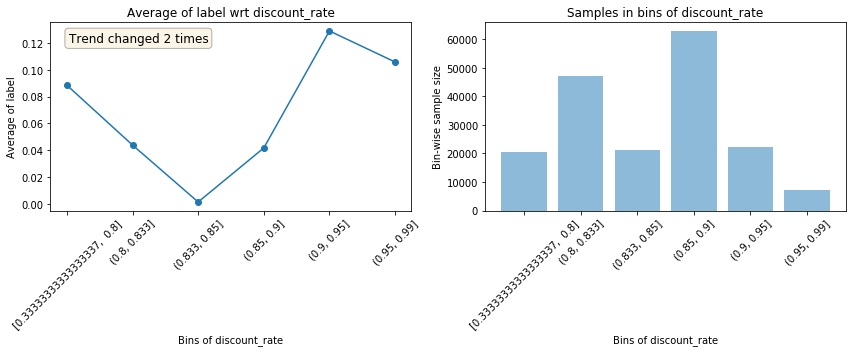

                                           Test data plots                                            


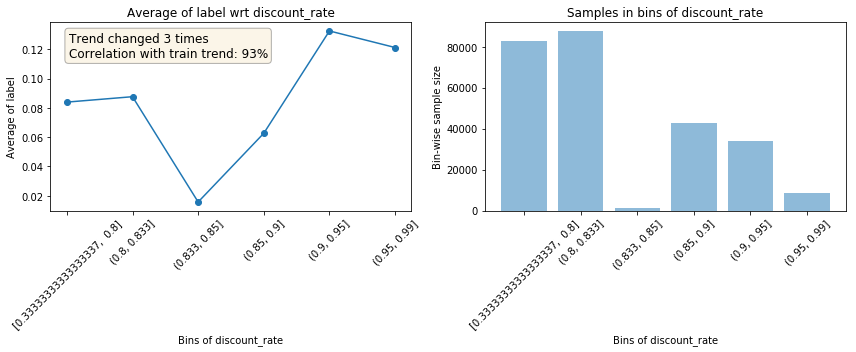

--------------------------------------------------------------------------------------------------------------


                                          Plots for distance                                          
                                           Train data plots                                           


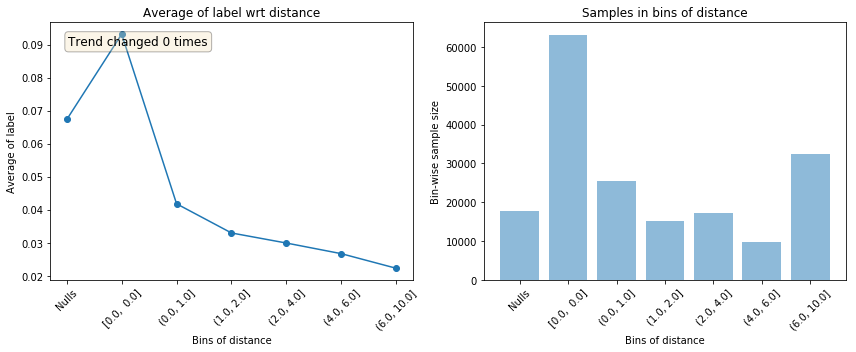

                                           Test data plots                                            


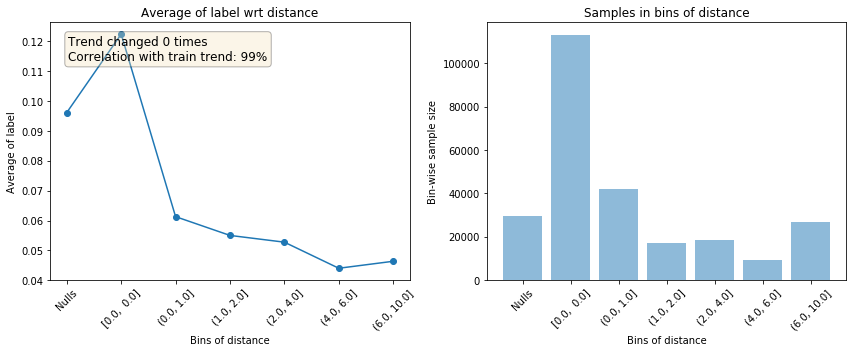

--------------------------------------------------------------------------------------------------------------


                                        Plots for day_of_month                                        
                                           Train data plots                                           


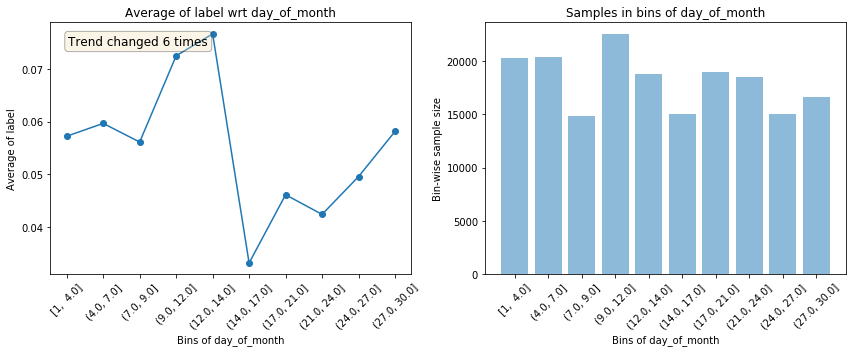

                                           Test data plots                                            


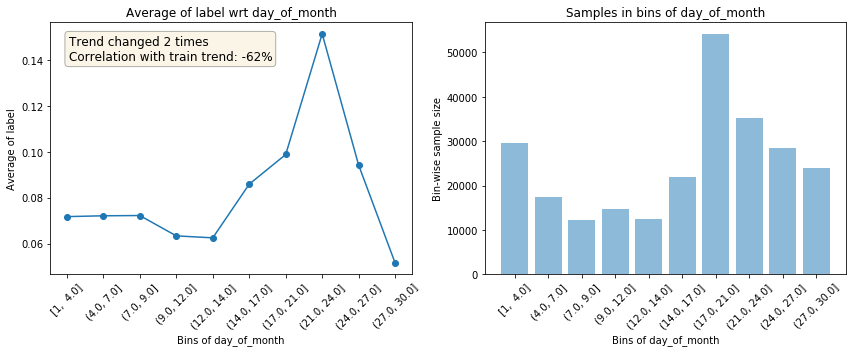

--------------------------------------------------------------------------------------------------------------


                                       Plots for days_distance                                        
                                           Train data plots                                           


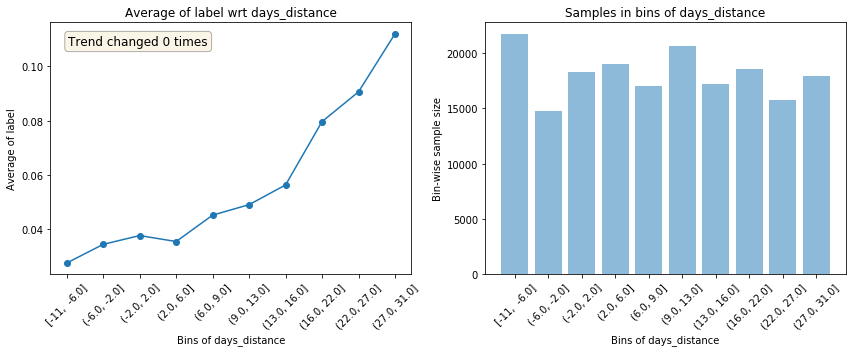

                                           Test data plots                                            


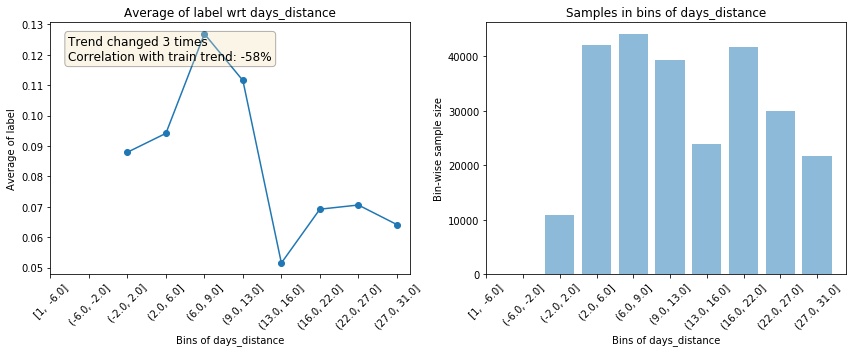

--------------------------------------------------------------------------------------------------------------


                                        Plots for discount_man                                        
                                           Train data plots                                           


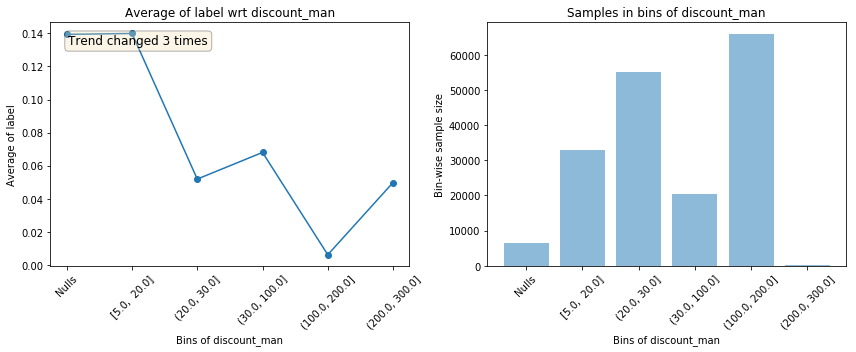

                                           Test data plots                                            


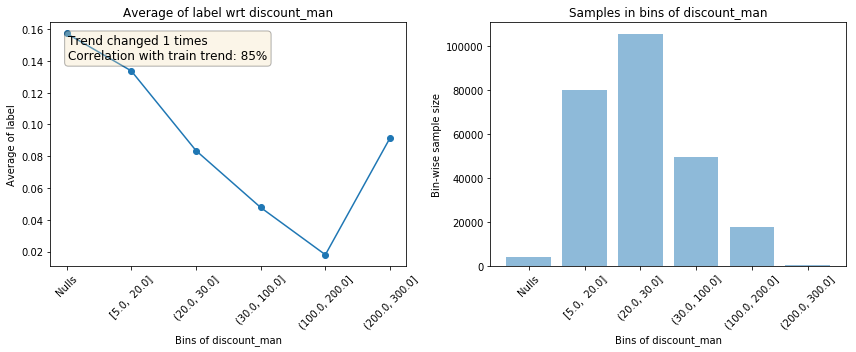

--------------------------------------------------------------------------------------------------------------


                                       Plots for discount_jian                                        
                                           Train data plots                                           


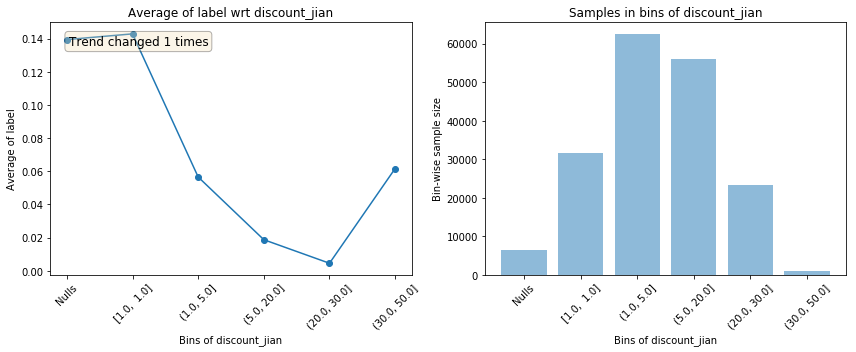

                                           Test data plots                                            


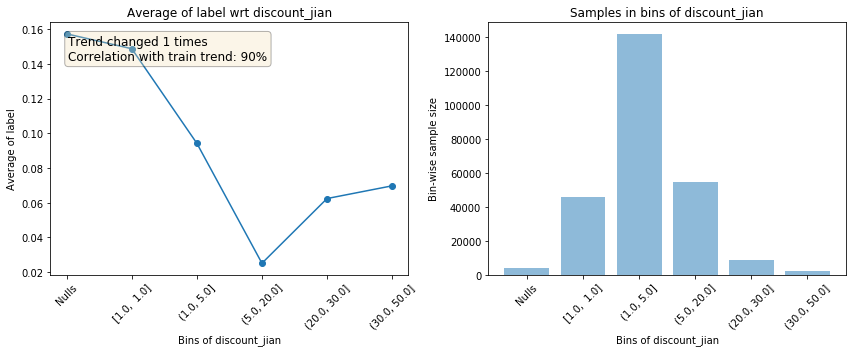

--------------------------------------------------------------------------------------------------------------


                                        Plots for is_man_jian                                         
Only one bin created for is_man_jian. Correlation can't be calculated
                                           Train data plots                                           


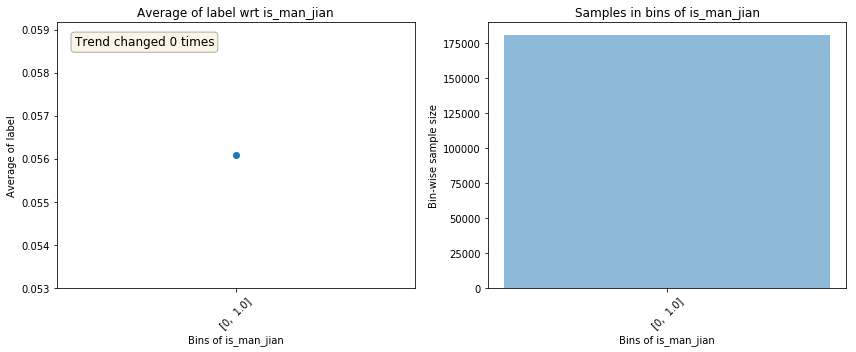

                                           Test data plots                                            


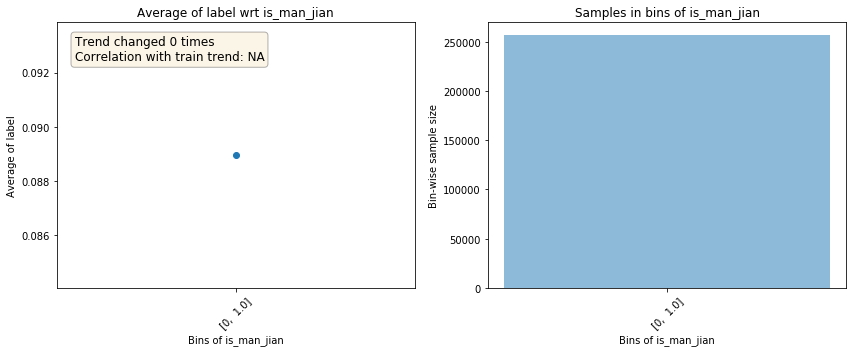

--------------------------------------------------------------------------------------------------------------


                                        Plots for total_sales                                         
                                           Train data plots                                           


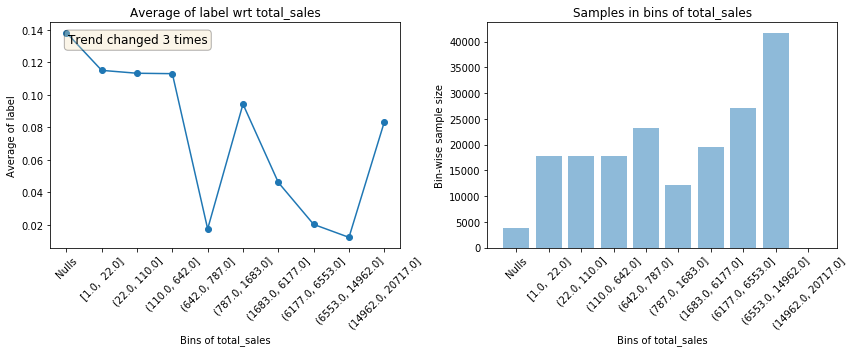

                                           Test data plots                                            


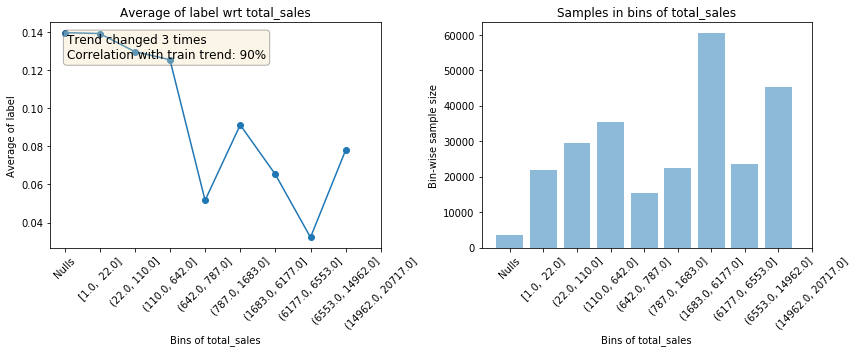

--------------------------------------------------------------------------------------------------------------


                                      Plots for sales_use_coupon                                      
                                           Train data plots                                           


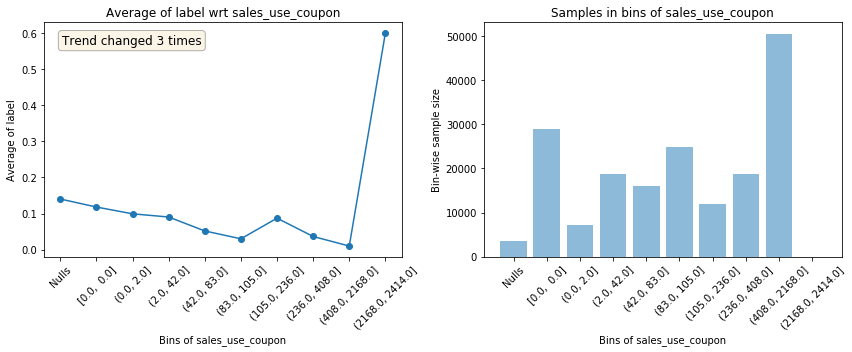

                                           Test data plots                                            


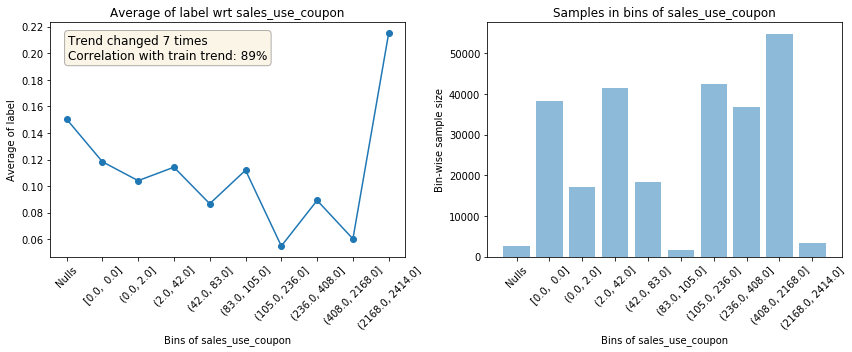

--------------------------------------------------------------------------------------------------------------


                                        Plots for total_coupon                                        
                                           Train data plots                                           


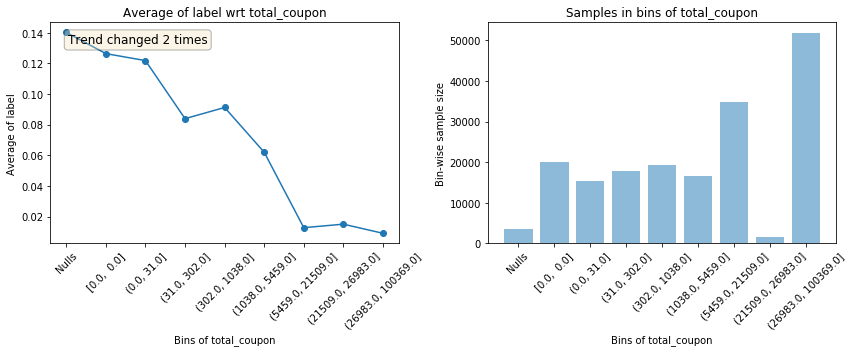

                                           Test data plots                                            


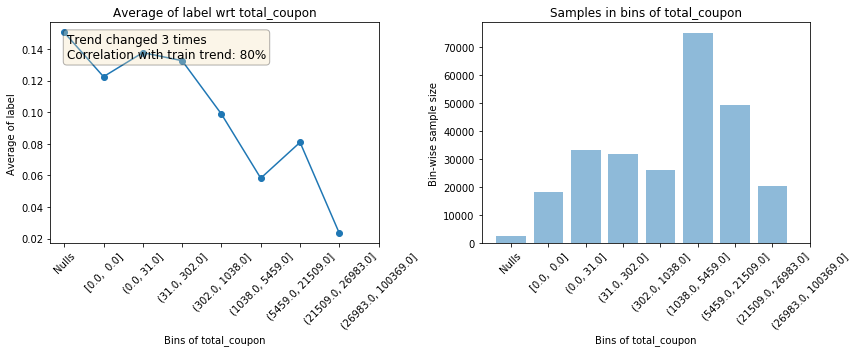

--------------------------------------------------------------------------------------------------------------


                                   Plots for merchant_min_distance                                    
                                           Train data plots                                           


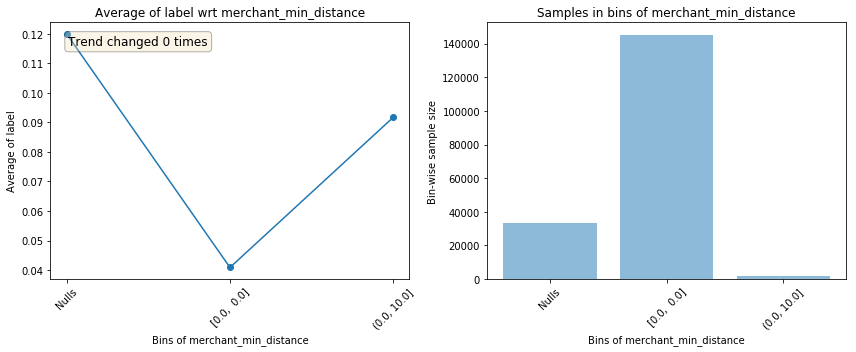

                                           Test data plots                                            


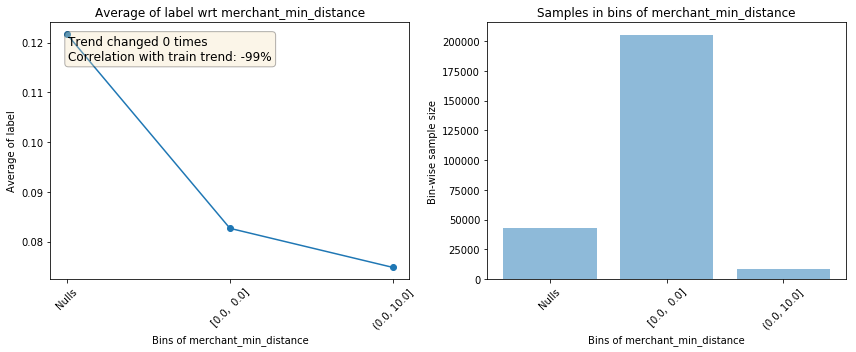

--------------------------------------------------------------------------------------------------------------


                                   Plots for merchant_max_distance                                    
                                           Train data plots                                           


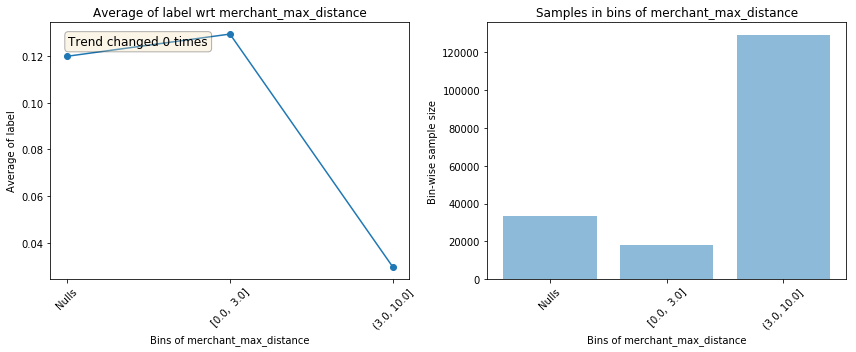

                                           Test data plots                                            


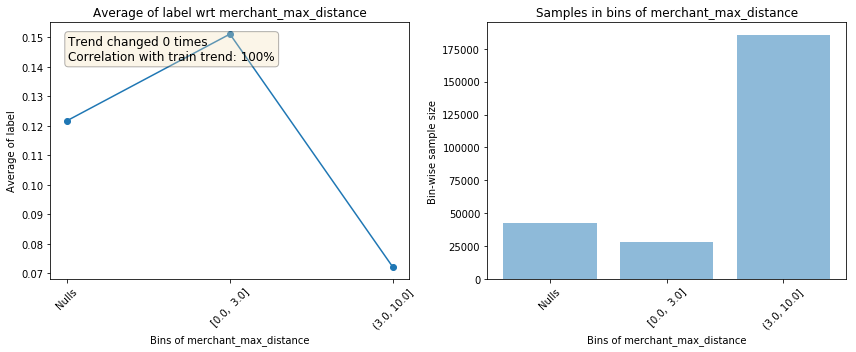

--------------------------------------------------------------------------------------------------------------


                                   Plots for merchant_mean_distance                                   
                                           Train data plots                                           


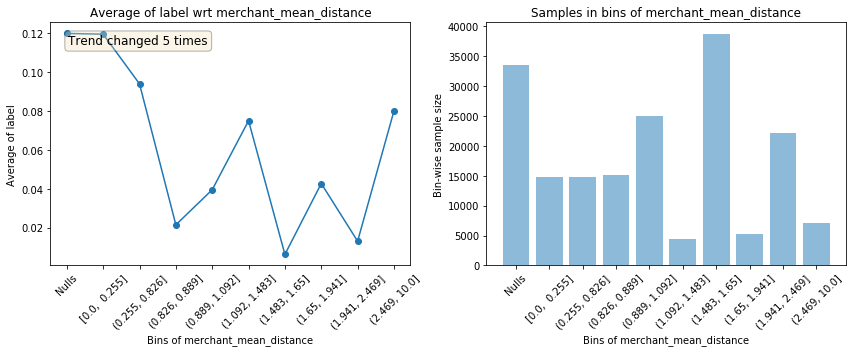

                                           Test data plots                                            


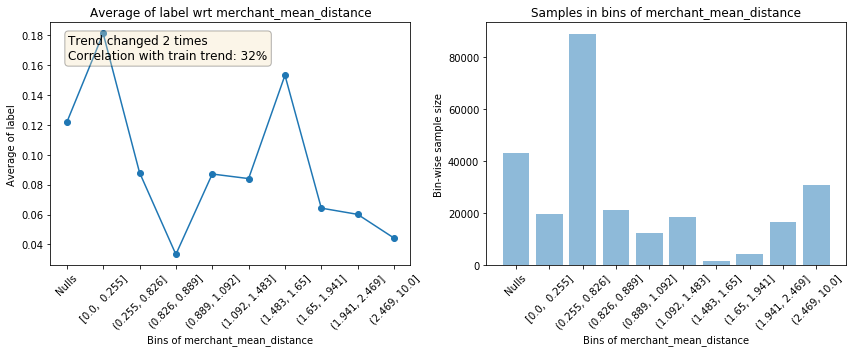

--------------------------------------------------------------------------------------------------------------


                                  Plots for merchant_median_distance                                  
                                           Train data plots                                           


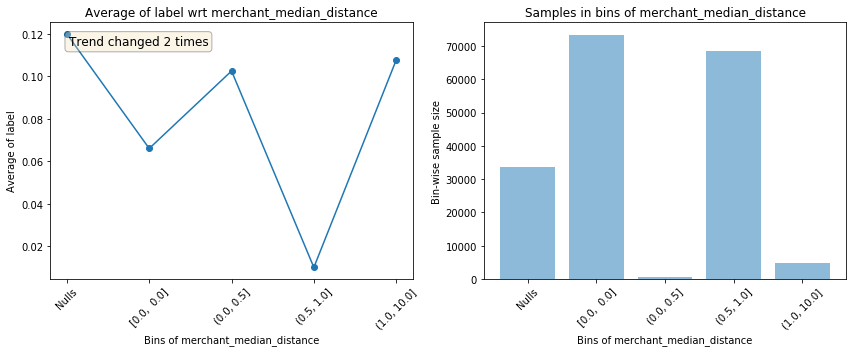

                                           Test data plots                                            


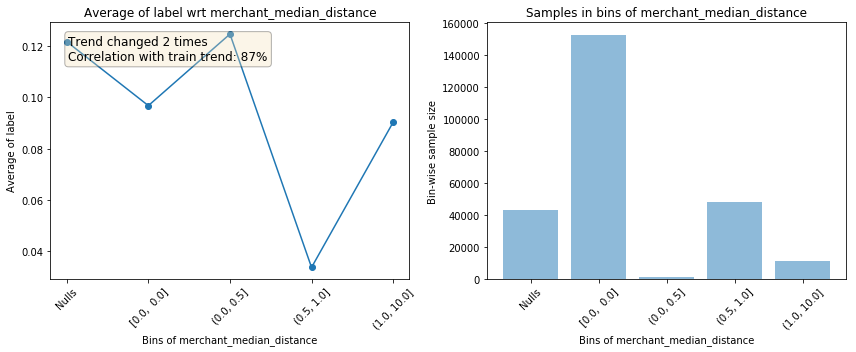

--------------------------------------------------------------------------------------------------------------


                               Plots for merchant_coupon_transfer_rate                                
                                           Train data plots                                           


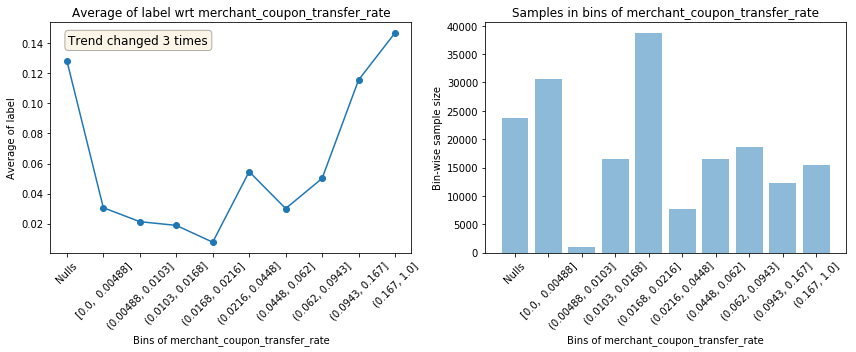

                                           Test data plots                                            


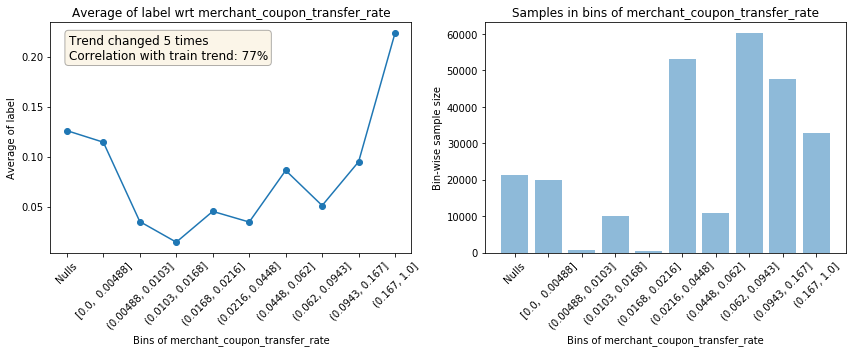

--------------------------------------------------------------------------------------------------------------


                                        Plots for coupon_rate                                         
                                           Train data plots                                           


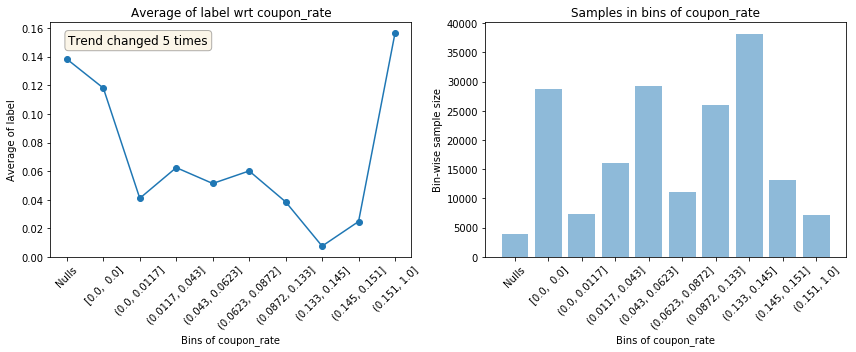

                                           Test data plots                                            


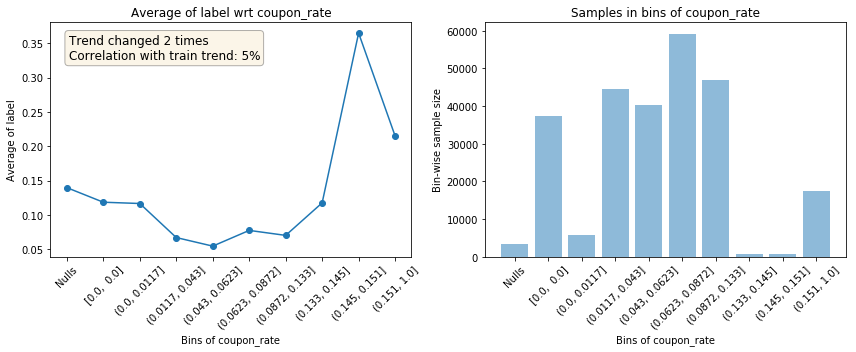

--------------------------------------------------------------------------------------------------------------


                                       Plots for count_merchant                                       
                                           Train data plots                                           


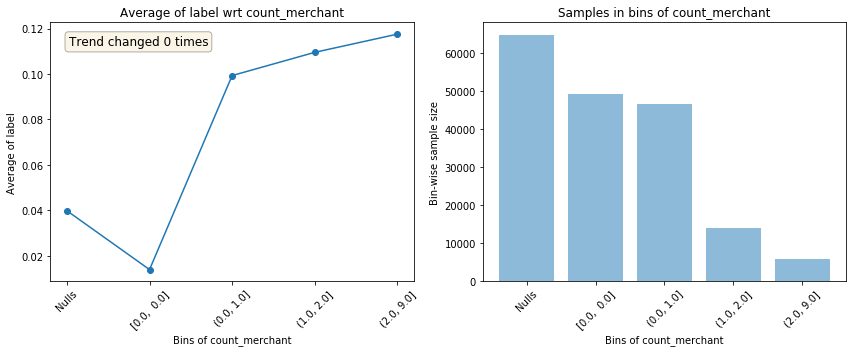

                                           Test data plots                                            


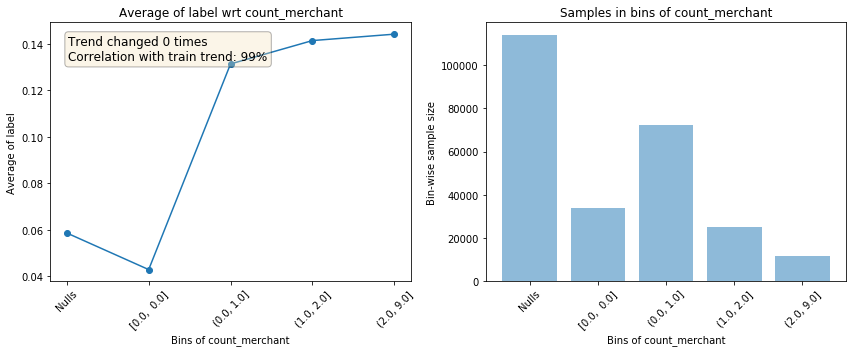

--------------------------------------------------------------------------------------------------------------


                                     Plots for user_min_distance                                      
                                           Train data plots                                           


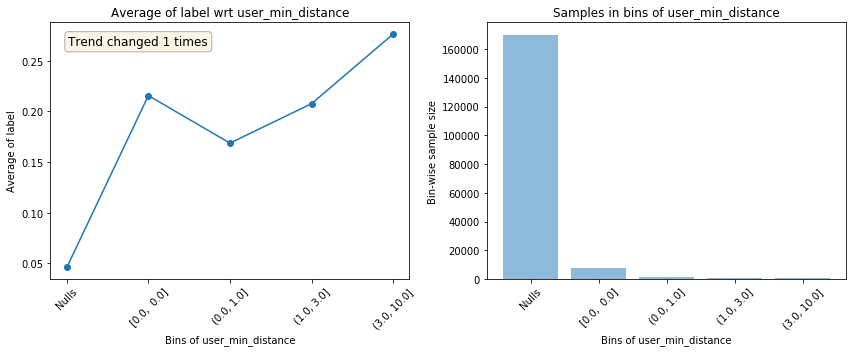

                                           Test data plots                                            


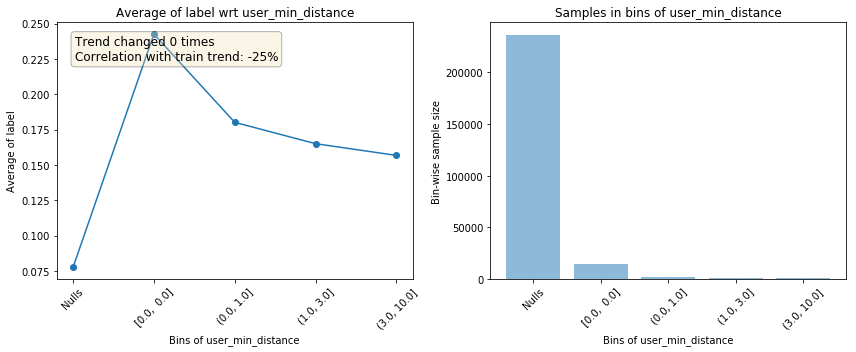

--------------------------------------------------------------------------------------------------------------


                                     Plots for user_max_distance                                      
                                           Train data plots                                           


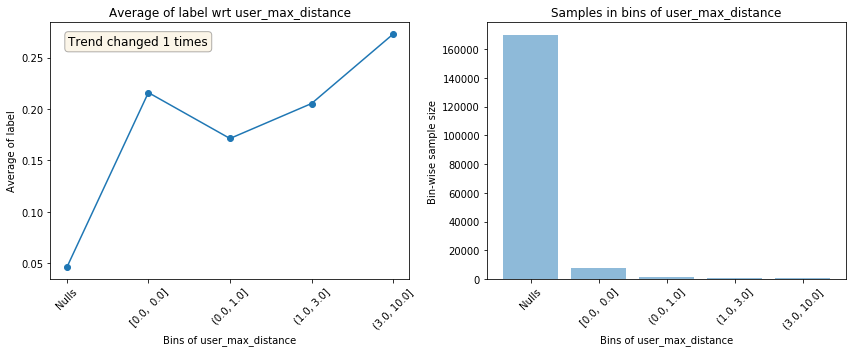

                                           Test data plots                                            


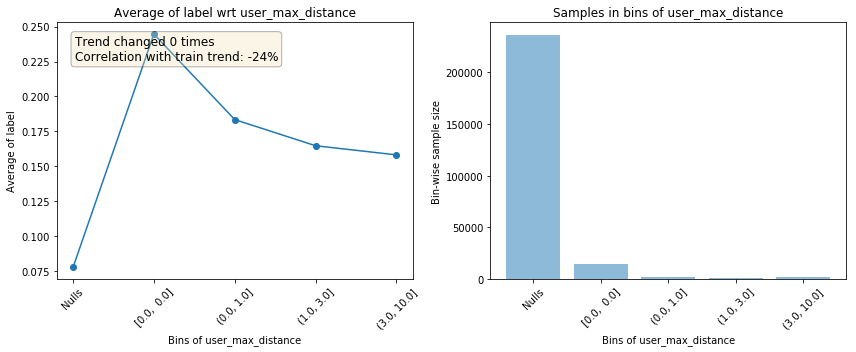

--------------------------------------------------------------------------------------------------------------


                                     Plots for user_mean_distance                                     
                                           Train data plots                                           


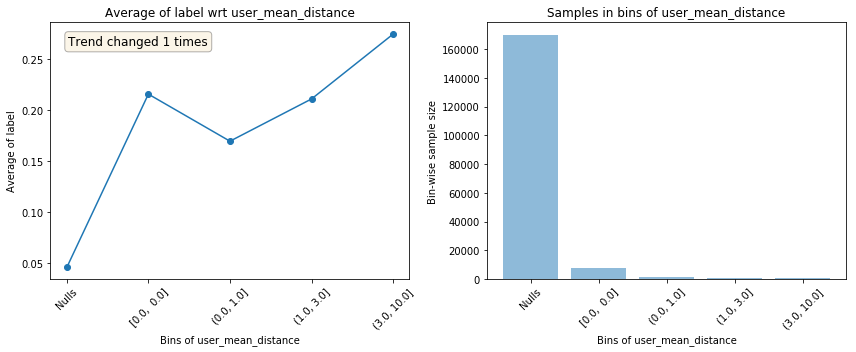

                                           Test data plots                                            


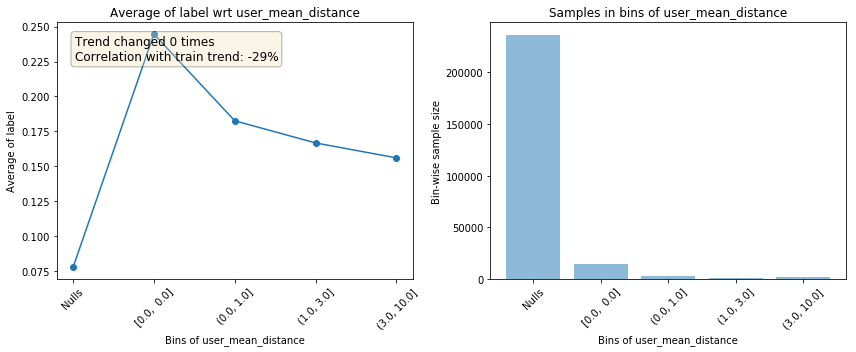

--------------------------------------------------------------------------------------------------------------


                                    Plots for user_median_distance                                    
                                           Train data plots                                           


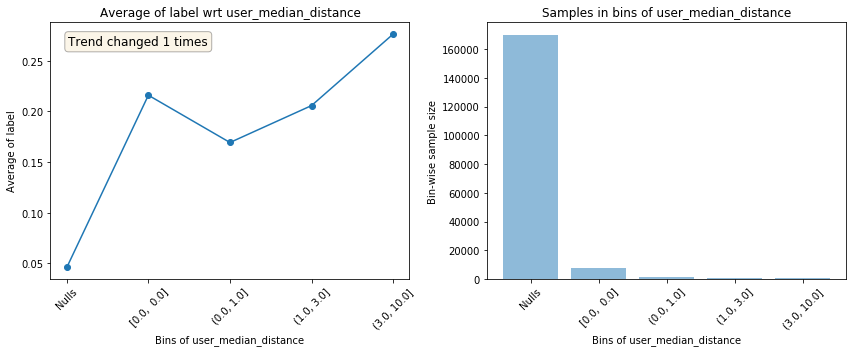

                                           Test data plots                                            


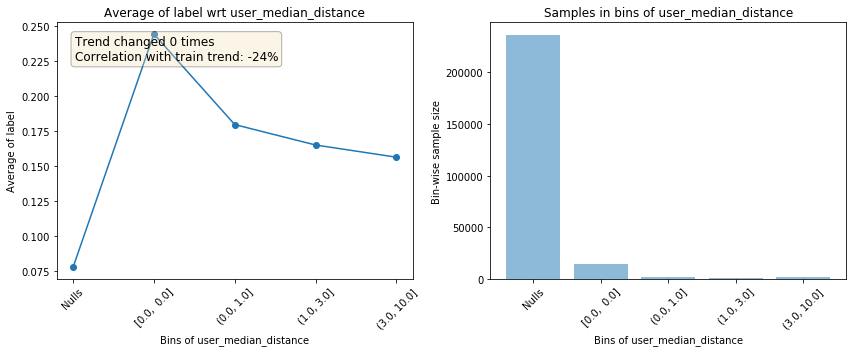

--------------------------------------------------------------------------------------------------------------


                                       Plots for buy_use_coupon                                       
                                           Train data plots                                           


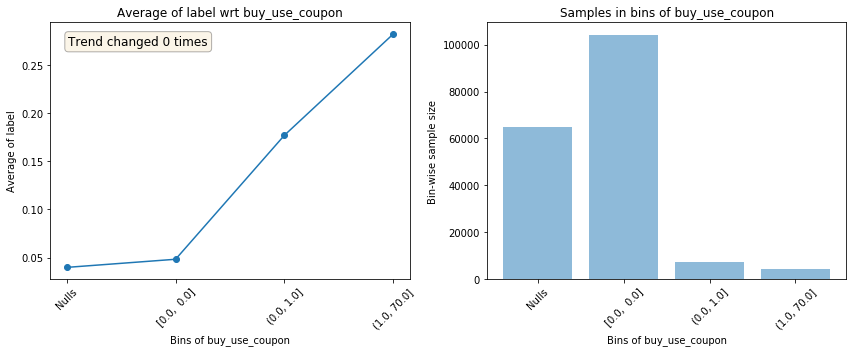

                                           Test data plots                                            


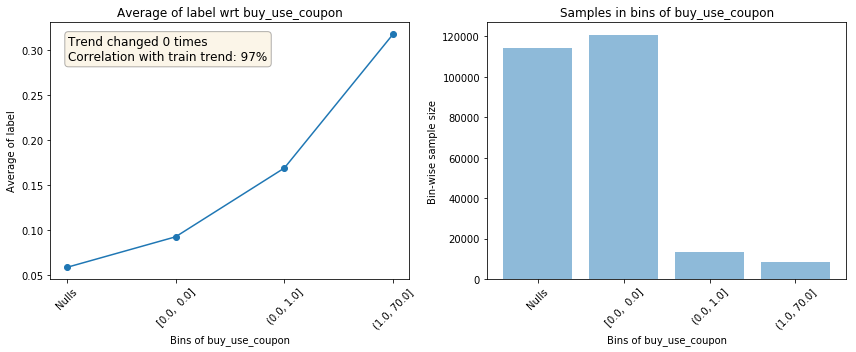

--------------------------------------------------------------------------------------------------------------


                                         Plots for buy_total                                          
                                           Train data plots                                           


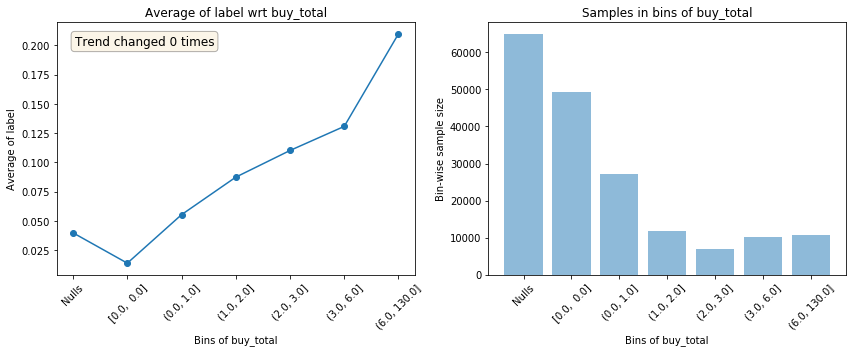

                                           Test data plots                                            


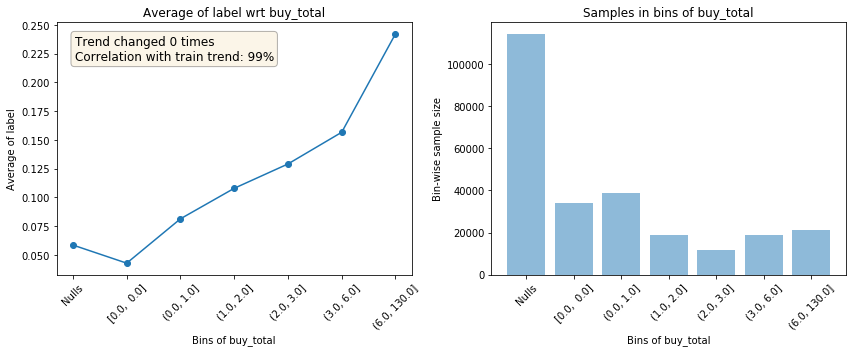

--------------------------------------------------------------------------------------------------------------


                                      Plots for coupon_received                                       
                                           Train data plots                                           


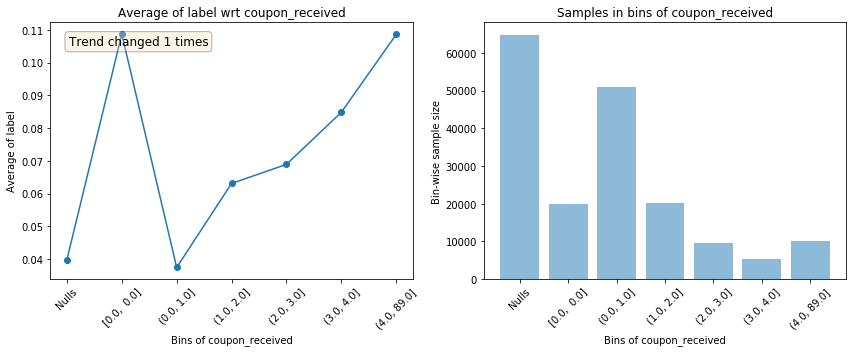

                                           Test data plots                                            


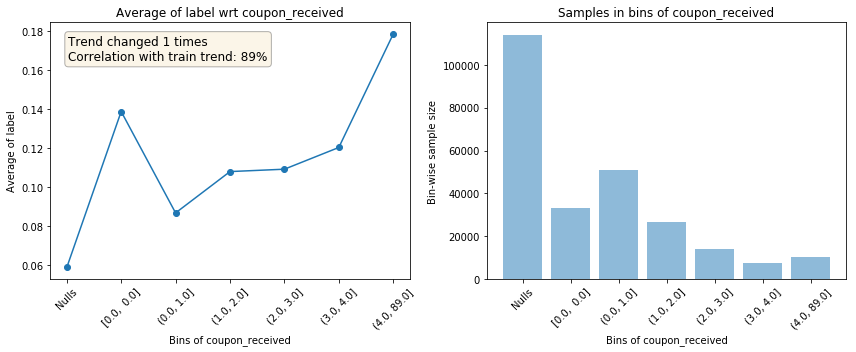

--------------------------------------------------------------------------------------------------------------


                               Plots for avg_user_date_datereceived_gap                               
                                           Train data plots                                           


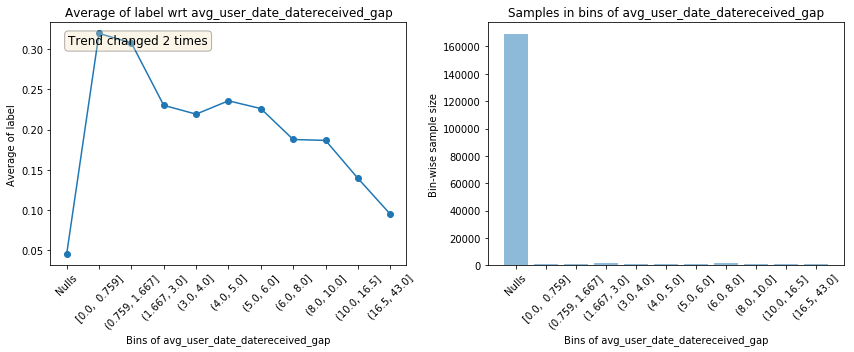

                                           Test data plots                                            


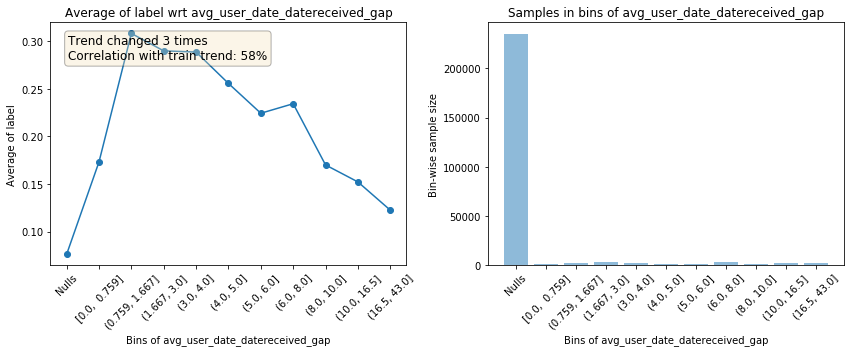

--------------------------------------------------------------------------------------------------------------


                               Plots for min_user_date_datereceived_gap                               
                                           Train data plots                                           


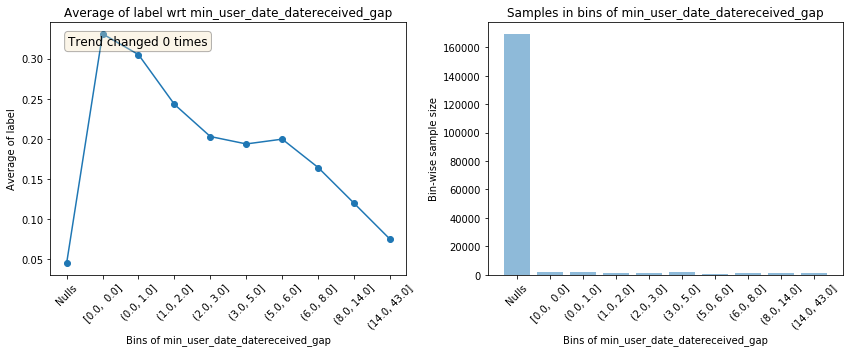

                                           Test data plots                                            


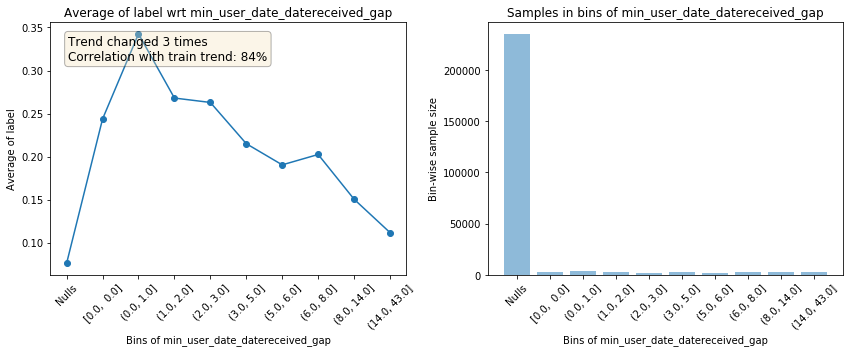

--------------------------------------------------------------------------------------------------------------


                               Plots for max_user_date_datereceived_gap                               
                                           Train data plots                                           


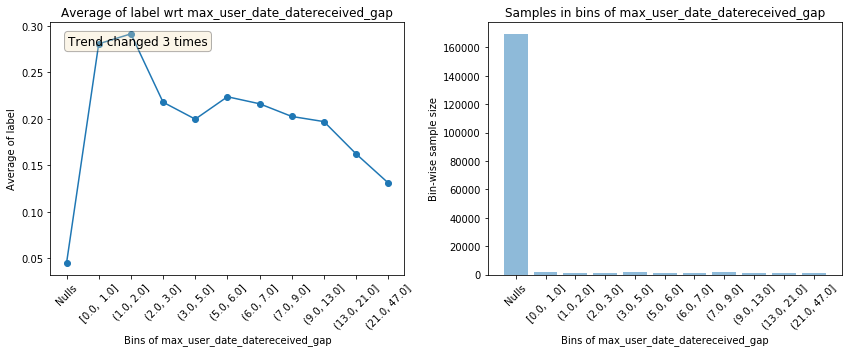

                                           Test data plots                                            


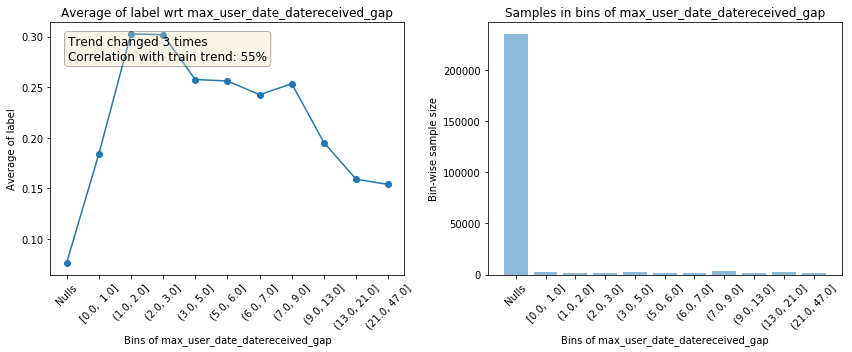

--------------------------------------------------------------------------------------------------------------


                                    Plots for buy_use_coupon_rate                                     
                                           Train data plots                                           


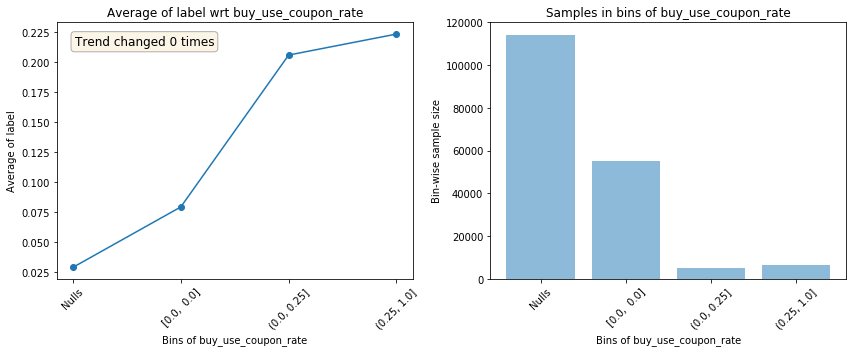

                                           Test data plots                                            


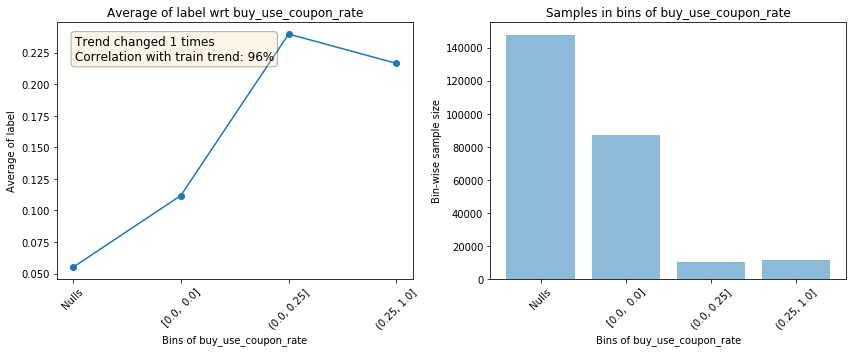

--------------------------------------------------------------------------------------------------------------


                                 Plots for user_coupon_transfer_rate                                  
                                           Train data plots                                           


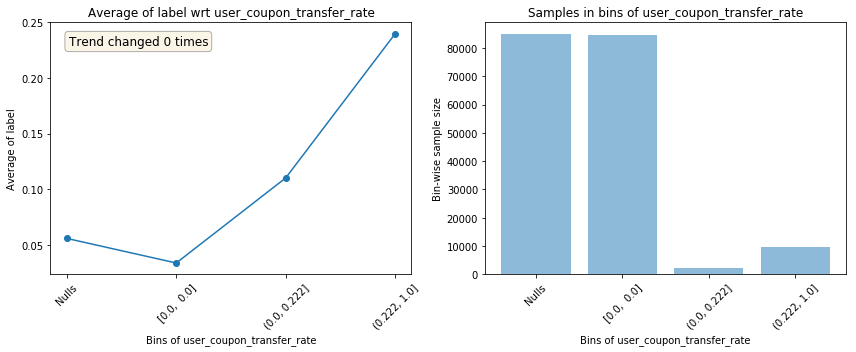

                                           Test data plots                                            


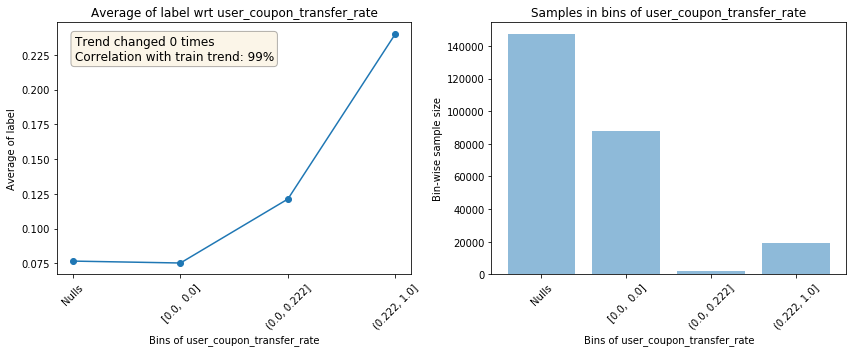

--------------------------------------------------------------------------------------------------------------


                                  Plots for user_merchant_buy_total                                   
                                           Train data plots                                           


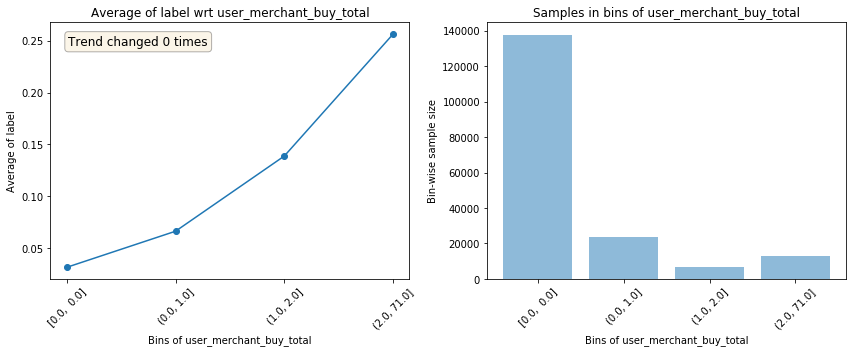

                                           Test data plots                                            


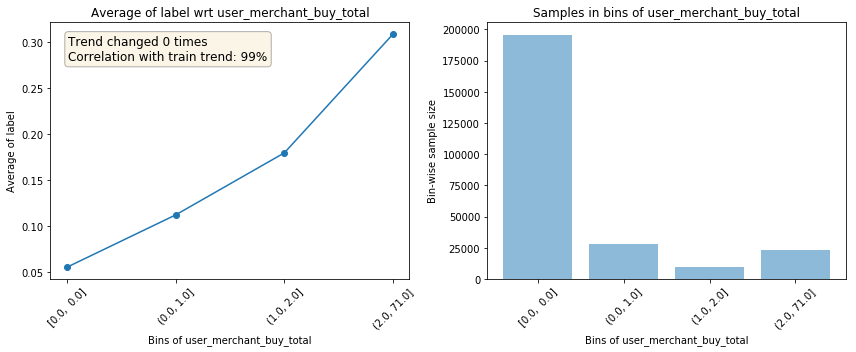

--------------------------------------------------------------------------------------------------------------


                                   Plots for user_merchant_received                                   
                                           Train data plots                                           


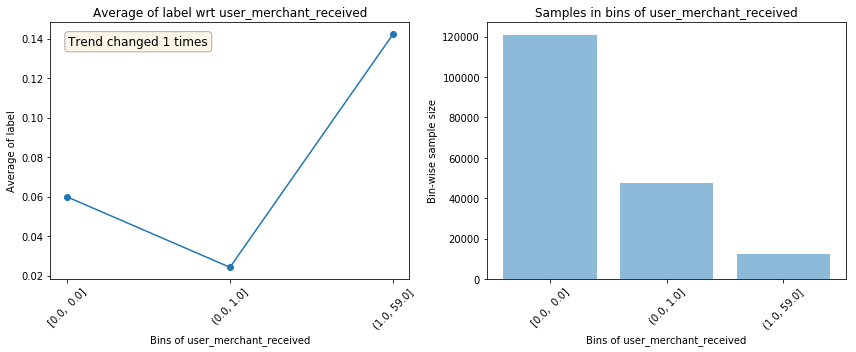

                                           Test data plots                                            


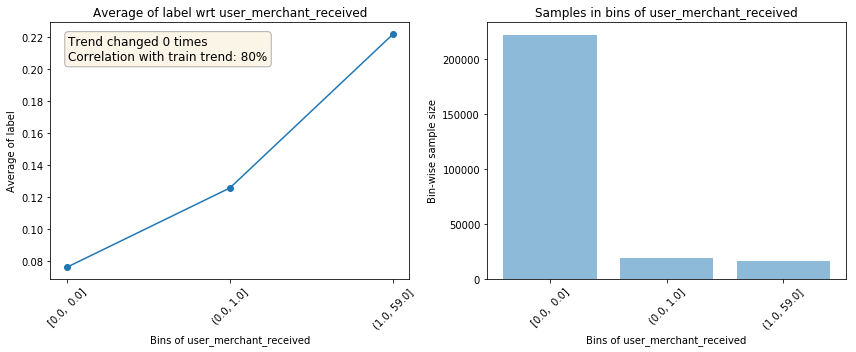

--------------------------------------------------------------------------------------------------------------


                                Plots for user_merchant_buy_use_coupon                                
                                           Train data plots                                           


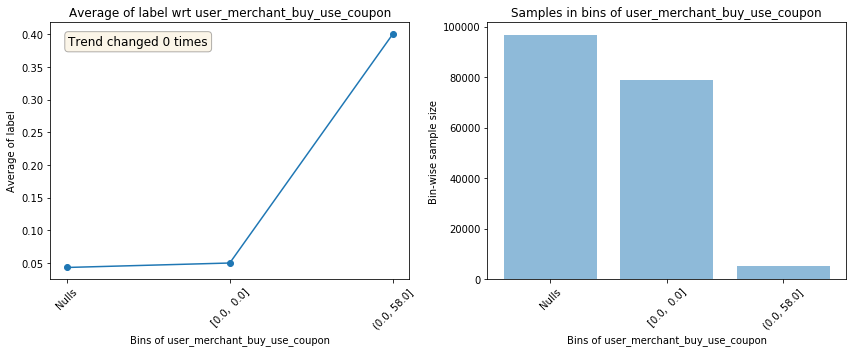

                                           Test data plots                                            


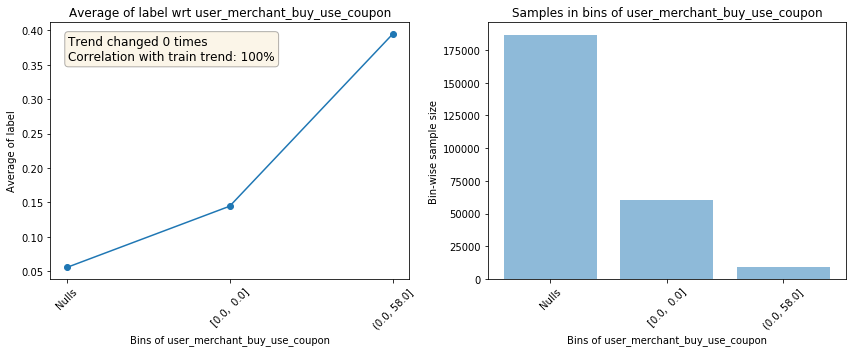

--------------------------------------------------------------------------------------------------------------


                                     Plots for user_merchant_any                                      
                                           Train data plots                                           


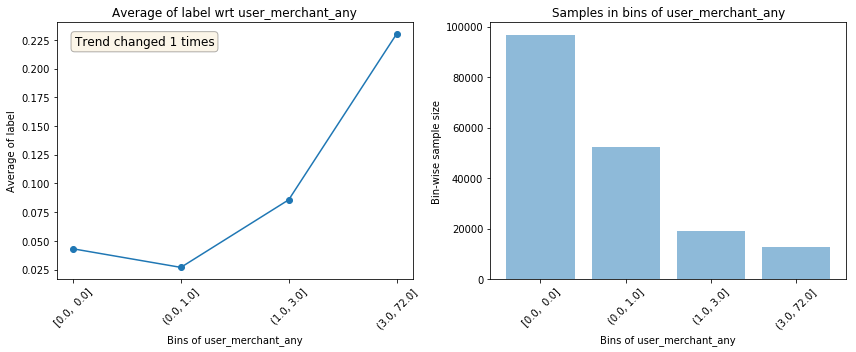

                                           Test data plots                                            


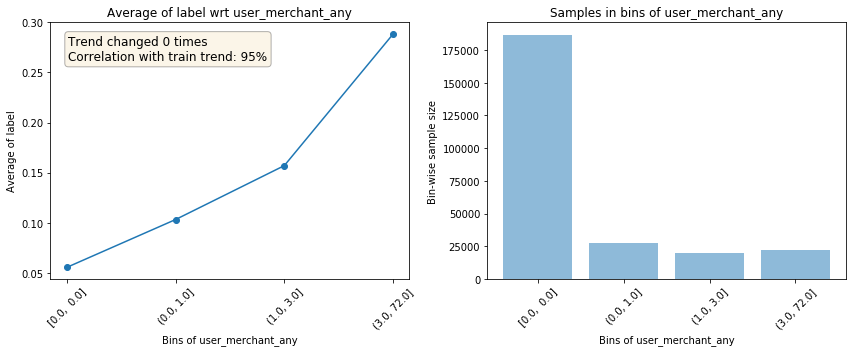

--------------------------------------------------------------------------------------------------------------


                                  Plots for user_merchant_buy_common                                  
                                           Train data plots                                           


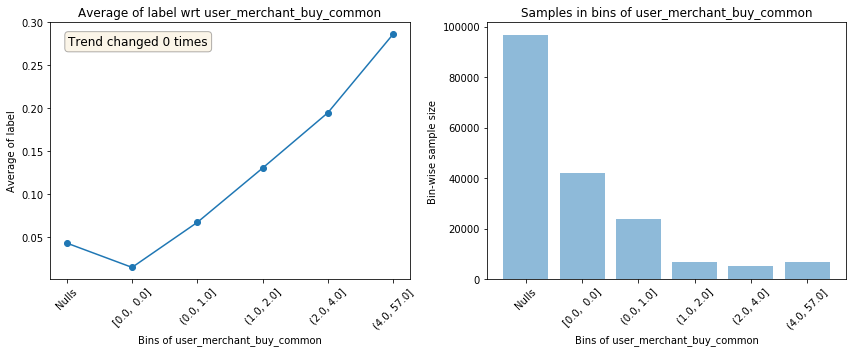

                                           Test data plots                                            


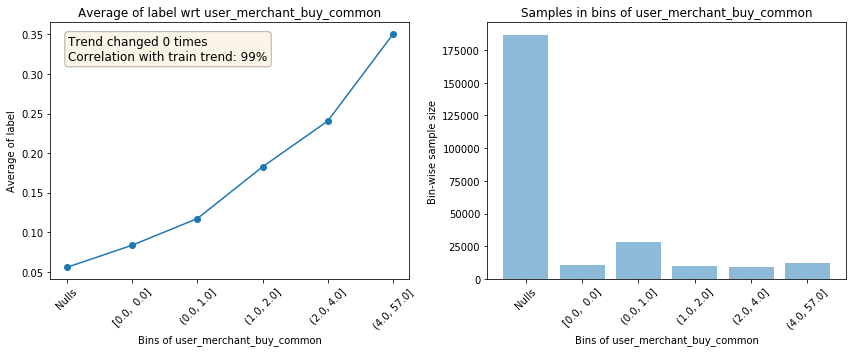

--------------------------------------------------------------------------------------------------------------


                             Plots for user_merchant_coupon_transfer_rate                             
                                           Train data plots                                           


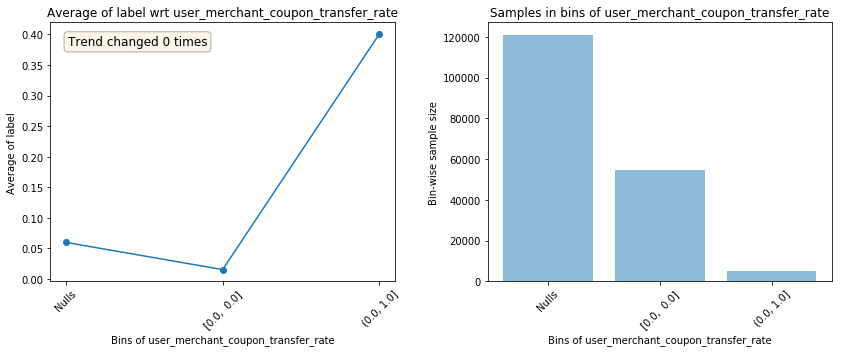

                                           Test data plots                                            


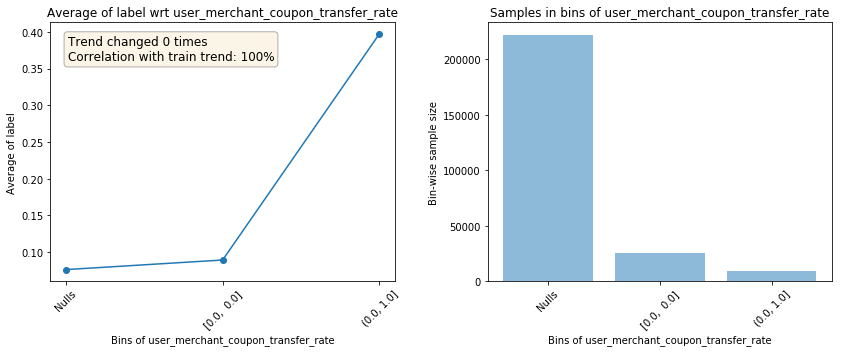

--------------------------------------------------------------------------------------------------------------


                               Plots for user_merchant_coupon_buy_rate                                
                                           Train data plots                                           


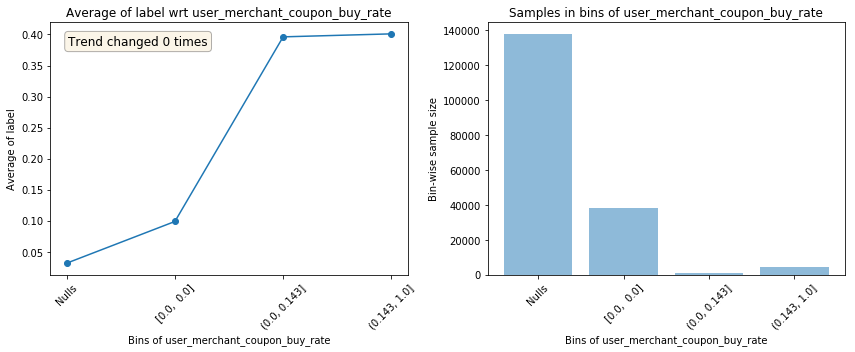

                                           Test data plots                                            


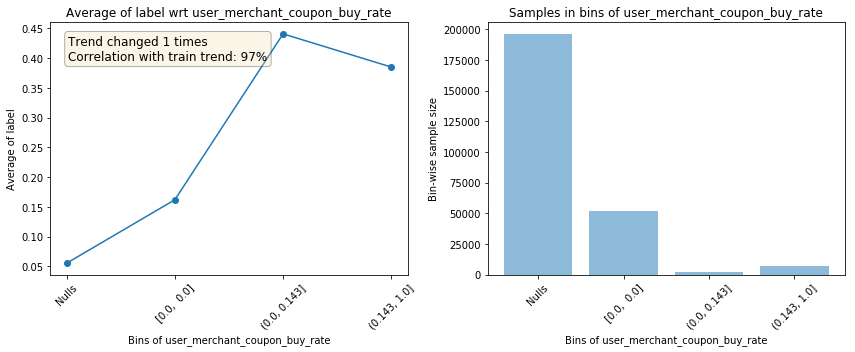

--------------------------------------------------------------------------------------------------------------


                                     Plots for user_merchant_rate                                     
                                           Train data plots                                           


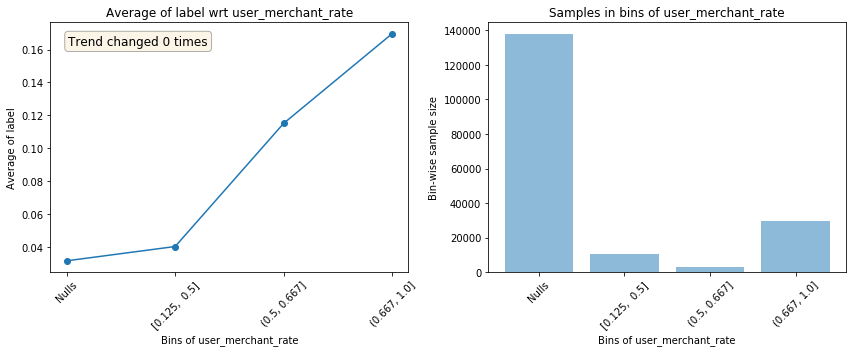

                                           Test data plots                                            


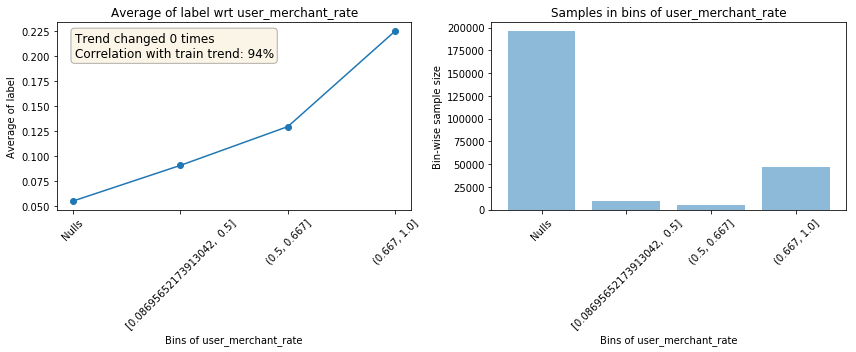

--------------------------------------------------------------------------------------------------------------


                               Plots for user_merchant_common_buy_rate                                
                                           Train data plots                                           


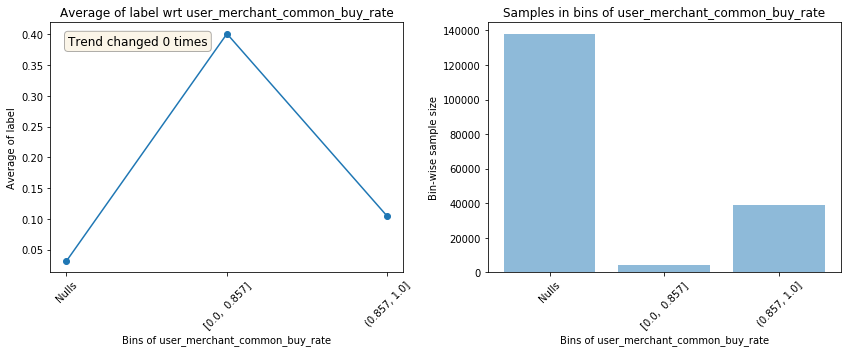

                                           Test data plots                                            


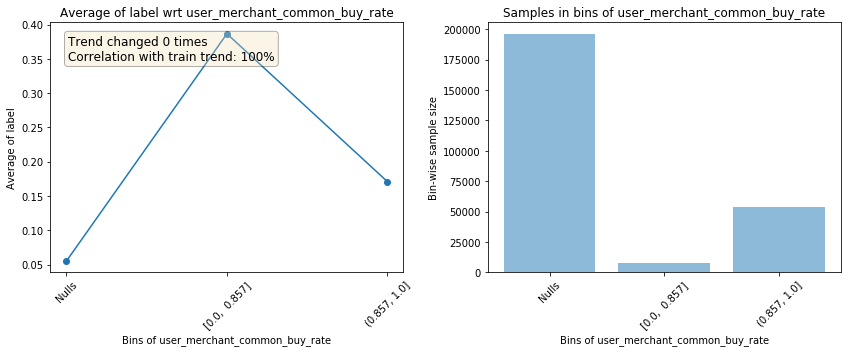

--------------------------------------------------------------------------------------------------------------


                          Plots for this_month_user_receive_same_coupn_count                          
                                           Train data plots                                           


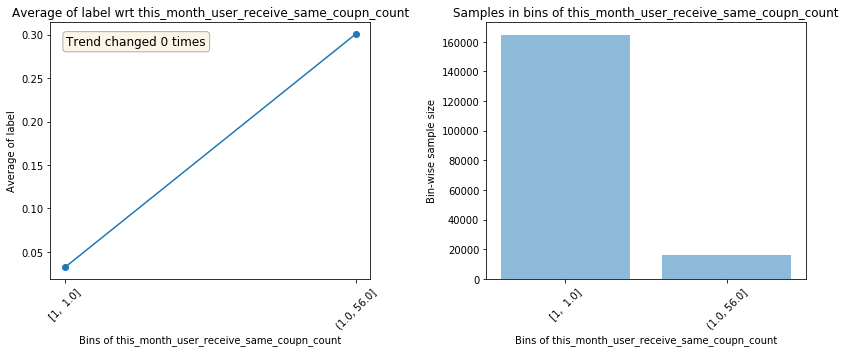

                                           Test data plots                                            


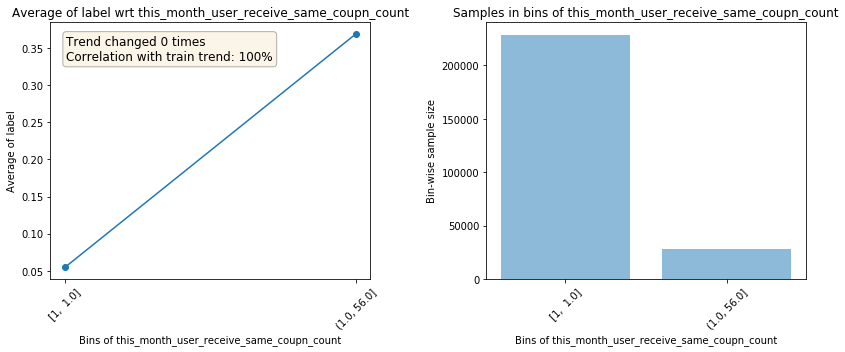

--------------------------------------------------------------------------------------------------------------


                          Plots for this_month_user_receive_all_coupon_count                          
                                           Train data plots                                           


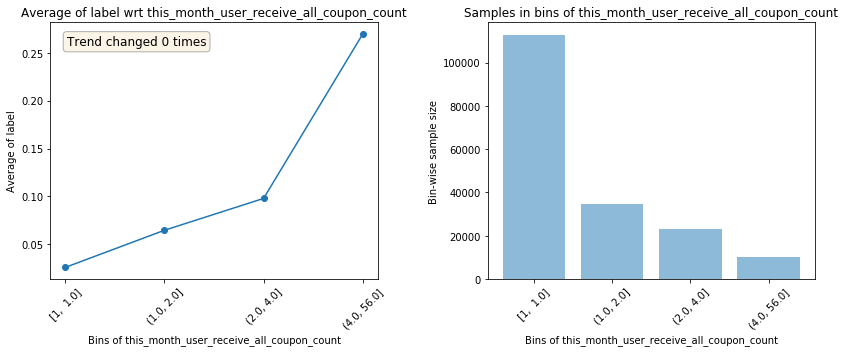

                                           Test data plots                                            


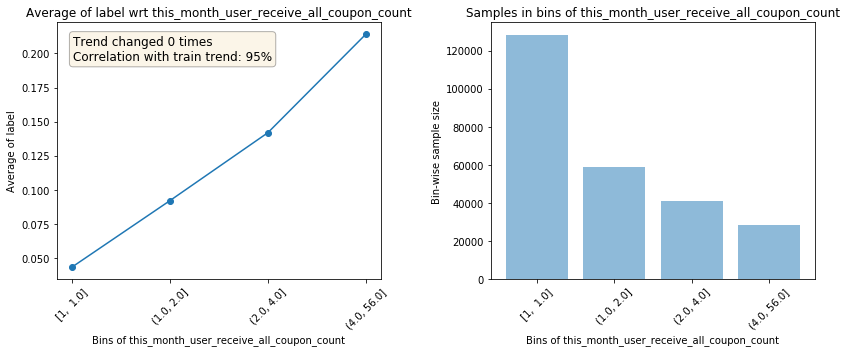

--------------------------------------------------------------------------------------------------------------


                        Plots for this_month_user_receive_same_coupon_lastone                         
                                           Train data plots                                           


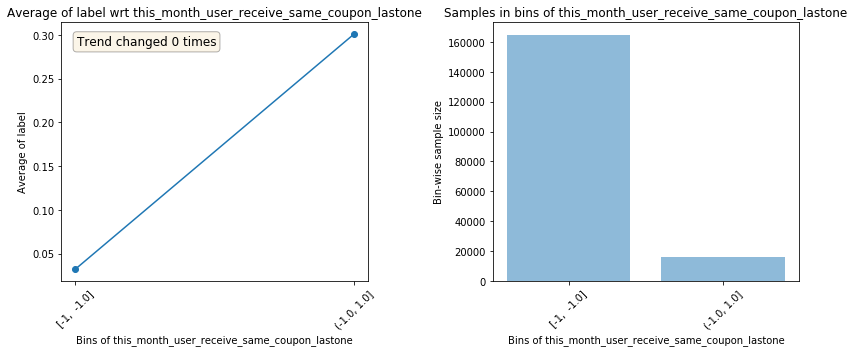

                                           Test data plots                                            


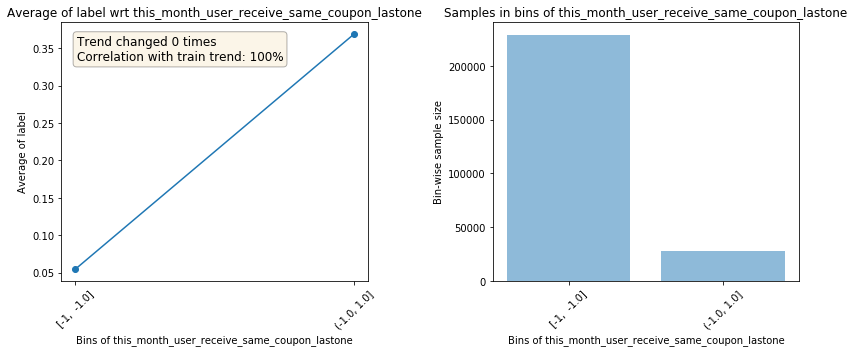

--------------------------------------------------------------------------------------------------------------


                        Plots for this_month_user_receive_same_coupon_firstone                        
                                           Train data plots                                           


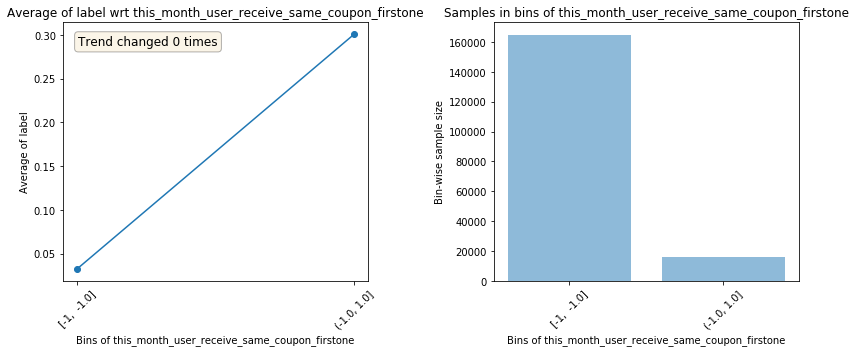

                                           Test data plots                                            


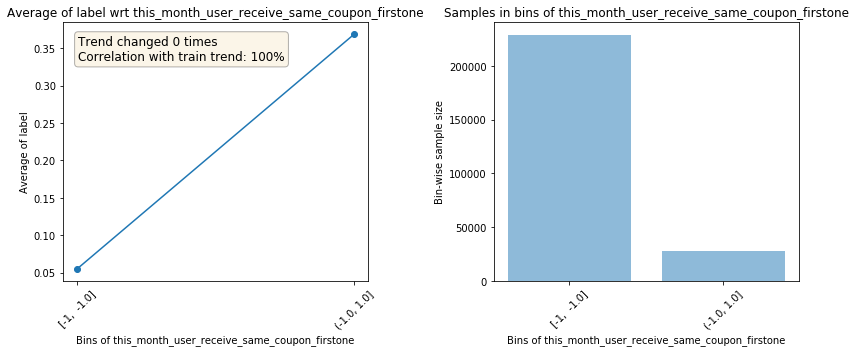

--------------------------------------------------------------------------------------------------------------


                             Plots for this_day_receive_all_coupon_count                              
                                           Train data plots                                           


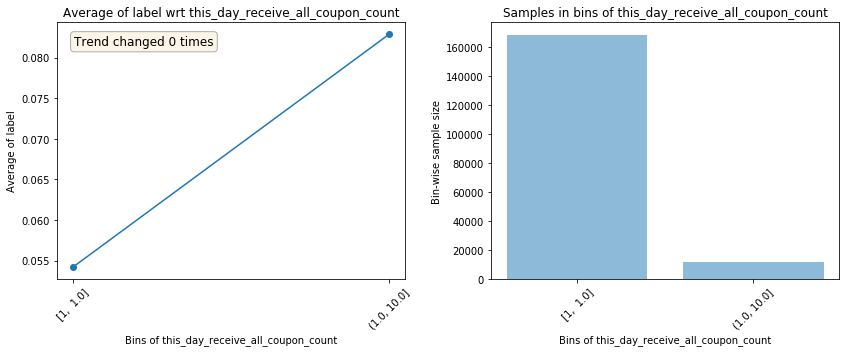

                                           Test data plots                                            


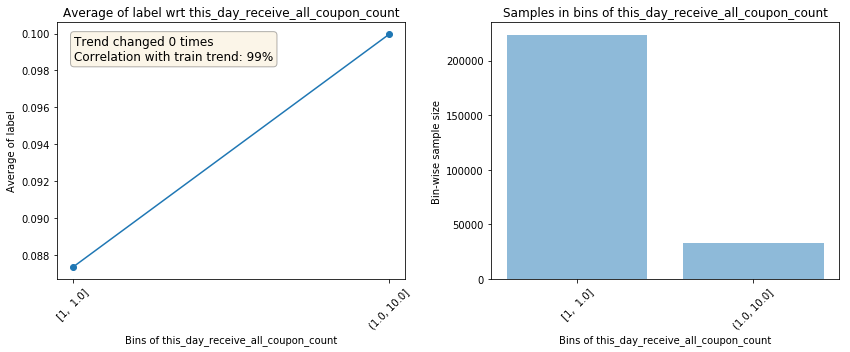

--------------------------------------------------------------------------------------------------------------


                          Plots for this_day_user_receive_same_coupon_count                           
                                           Train data plots                                           


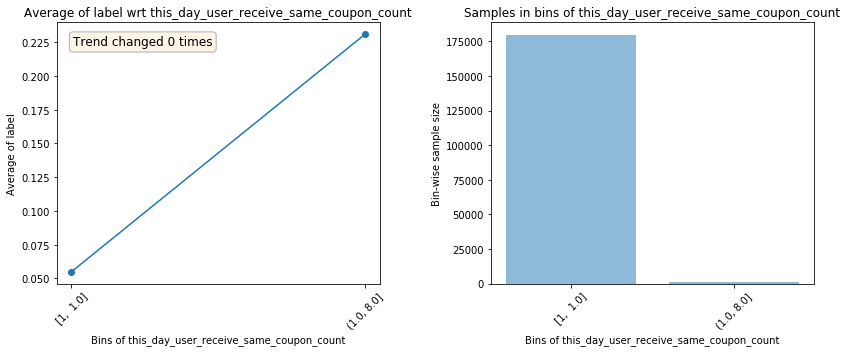

                                           Test data plots                                            


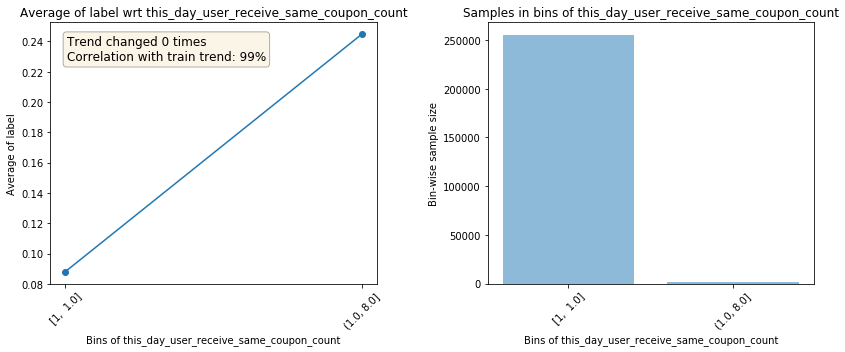

--------------------------------------------------------------------------------------------------------------


                                         Plots for is_weekend                                         
                                           Train data plots                                           


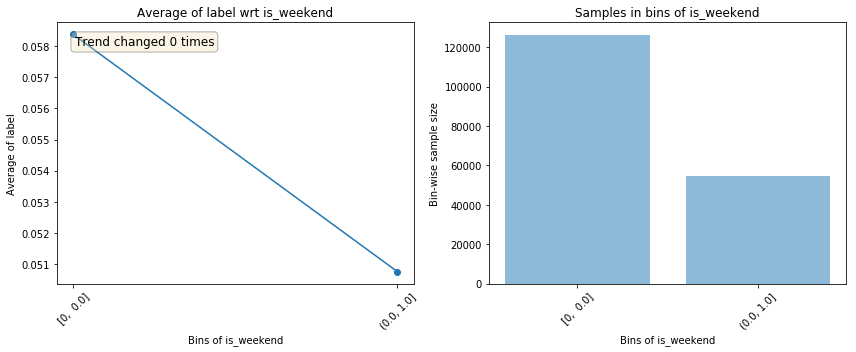

                                           Test data plots                                            


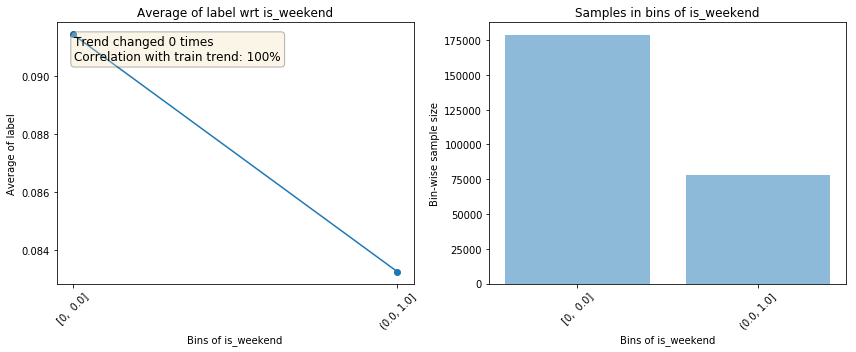

--------------------------------------------------------------------------------------------------------------


                                          Plots for weekday1                                          
                                           Train data plots                                           


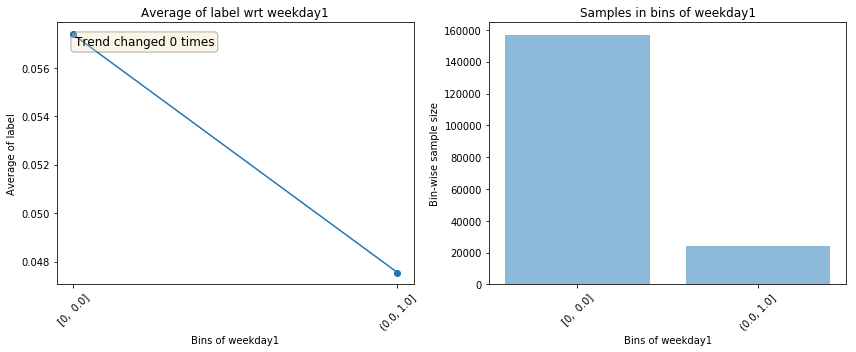

                                           Test data plots                                            


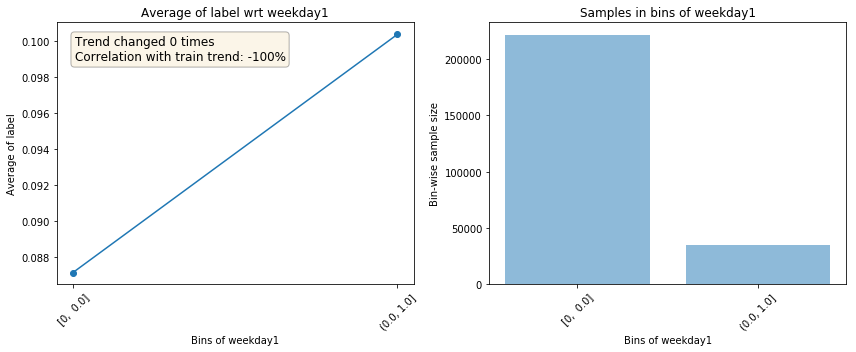

--------------------------------------------------------------------------------------------------------------


                                          Plots for weekday2                                          
                                           Train data plots                                           


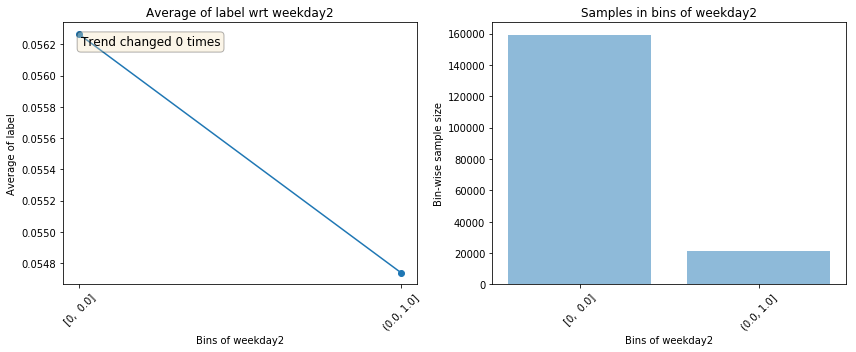

                                           Test data plots                                            


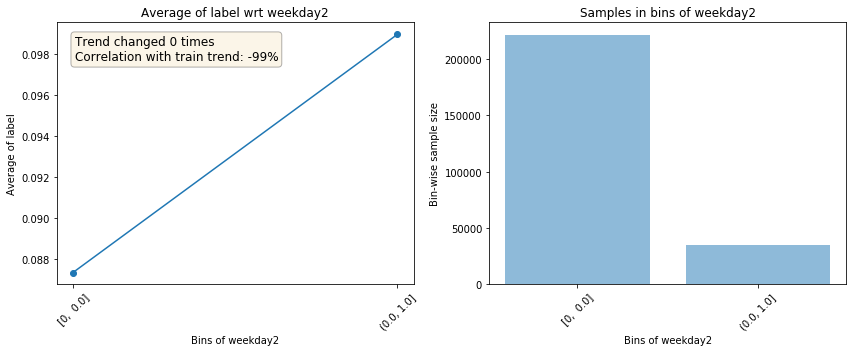

--------------------------------------------------------------------------------------------------------------


                                          Plots for weekday3                                          
                                           Train data plots                                           


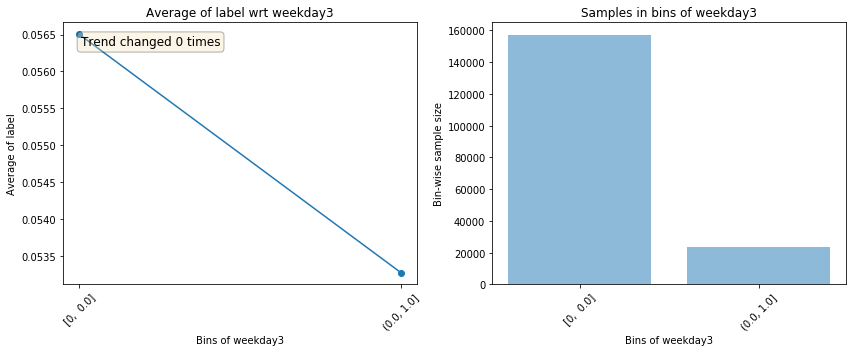

                                           Test data plots                                            


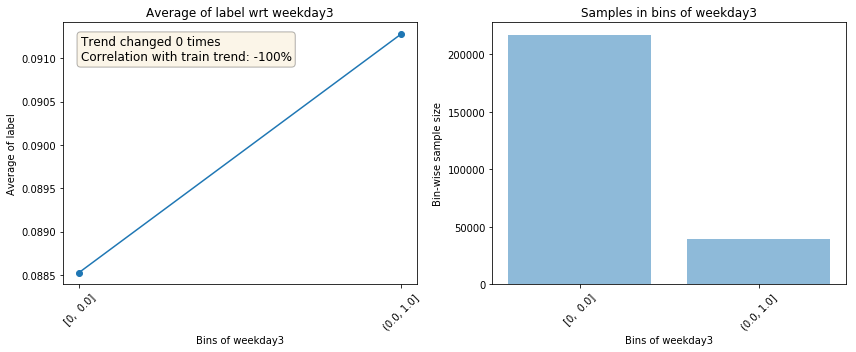

--------------------------------------------------------------------------------------------------------------


                                          Plots for weekday4                                          
                                           Train data plots                                           


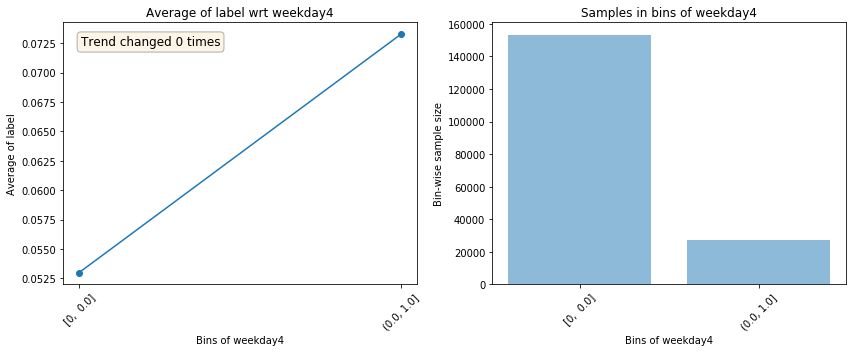

                                           Test data plots                                            


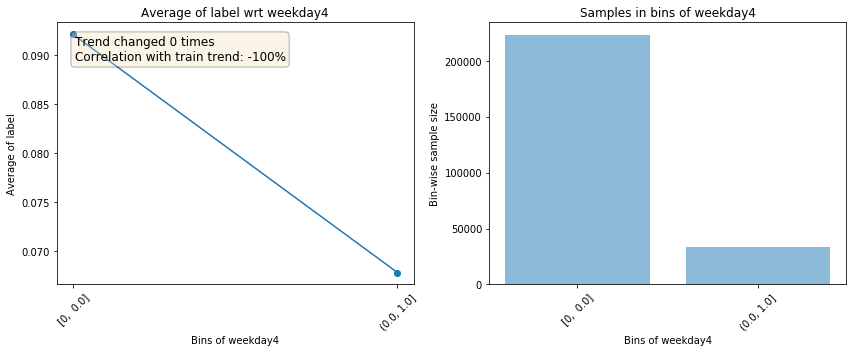

--------------------------------------------------------------------------------------------------------------


                                          Plots for weekday5                                          
                                           Train data plots                                           


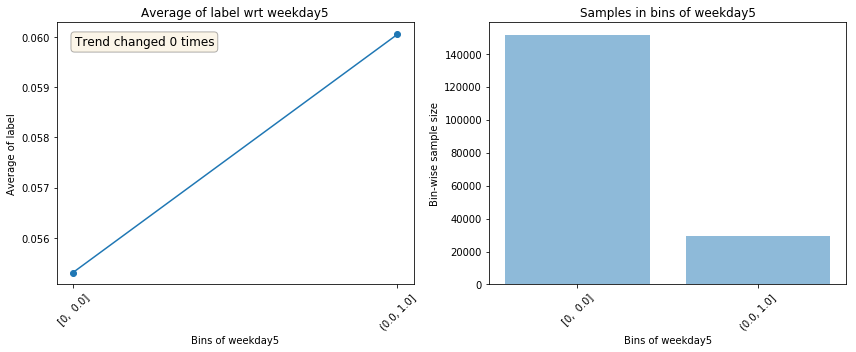

                                           Test data plots                                            


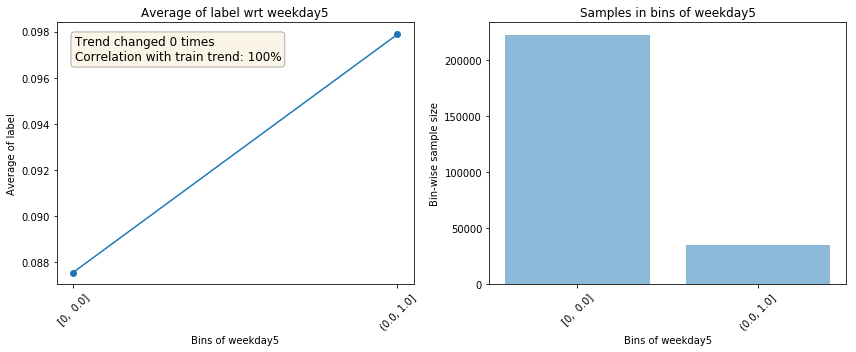

--------------------------------------------------------------------------------------------------------------


                                          Plots for weekday6                                          
                                           Train data plots                                           


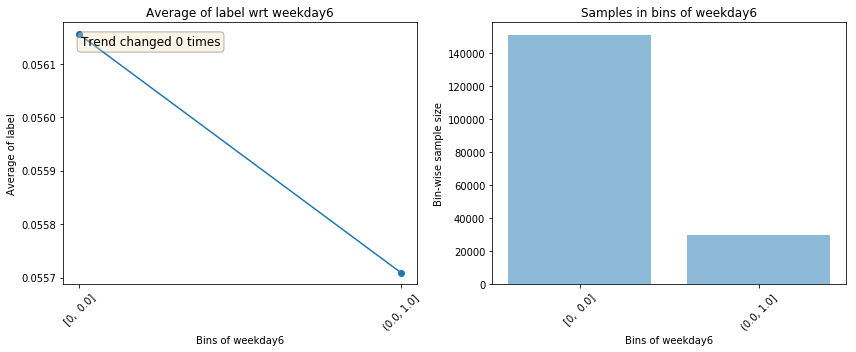

                                           Test data plots                                            


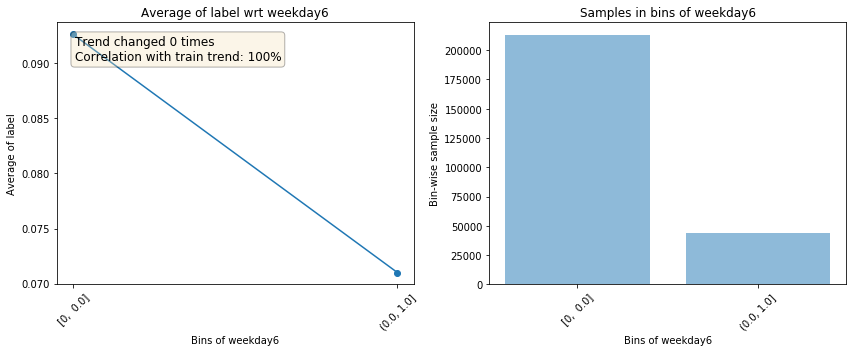

--------------------------------------------------------------------------------------------------------------


                                          Plots for weekday7                                          
                                           Train data plots                                           


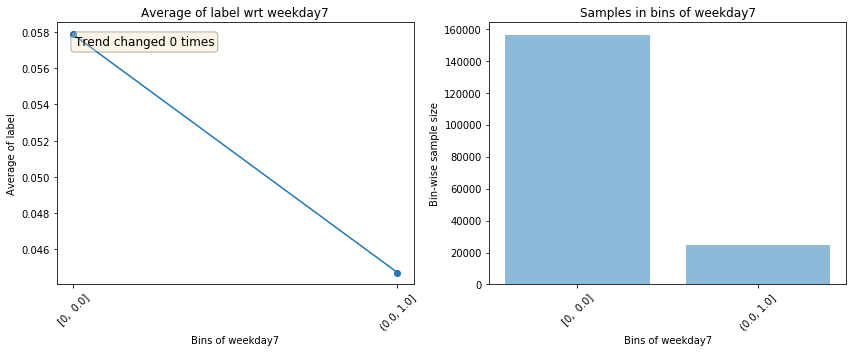

                                           Test data plots                                            


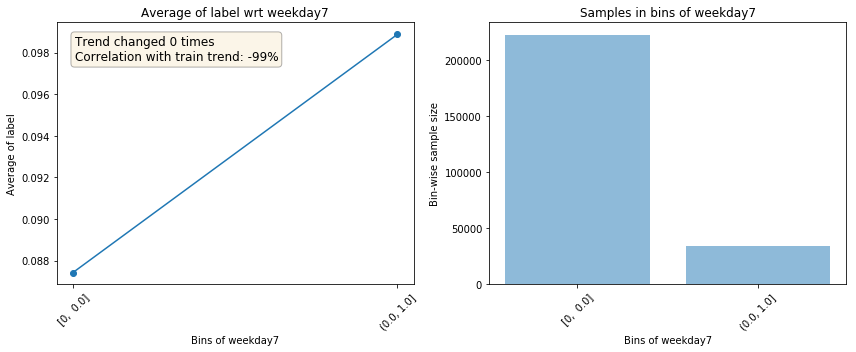

--------------------------------------------------------------------------------------------------------------




In [23]:
from featexp import get_univariate_plots
data_train = dataset1.drop(['user_id','day_gap_before','coupon_id','day_gap_after'],axis=1)   
data_test = dataset2.drop(['user_id','day_gap_before','coupon_id','day_gap_after'],axis=1)   
get_univariate_plots(data=data_train, target_col='label', data_test=data_test)


In [26]:
from featexp import get_trend_stats
stats = get_trend_stats(data=data_train, target_col='label', data_test=data_test)

Only one bin created for is_man_jian. Correlation can't be calculated
Returning stats for all numeric features


In [31]:
stats.sort_values('Trend_correlation', ascending=False)

Feature  Trend_changes  \
11                         merchant_max_distance              0   
44                                    is_weekend              0   
41  this_month_user_receive_same_coupon_firstone              0   
38      this_month_user_receive_same_coupn_count              0   
31                  user_merchant_buy_use_coupon              0   
37                 user_merchant_common_buy_rate              0   
40   this_month_user_receive_same_coupon_lastone              0   
34            user_merchant_coupon_transfer_rate              0   
49                                      weekday5              0   
50                                      weekday6              0   
43       this_day_user_receive_same_coupon_count              0   
42             this_day_receive_all_coupon_count              0   
16                                count_merchant              0   
22                                     buy_total              0   
29                       user_merchant_buy_total              0   
33                      user_merchant_buy_common              0   
1                                       distance              0   
28                     user_coupon_transfer_rate              0   
35                 user_merchant_coupon_buy_rate              0   
21                                buy_use_coupon              0   
27                           buy_use_coupon_rate              0   
32                             user_merchant_any              1   
39      this_month_user_receive_all_coupon_count              0   
36                            user_merchant_rate              0   
0                                  discount_rate              2   
7                                    total_sales              3   
5                                  discount_jian              1   
23                               coupon_received              1   
8                               sales_use_coupon              3   
13                      merchant_median_distance              2   
4                                   discount_man              3   
25                min_user_date_datereceived_gap              0   
9                                   total_coupon              2   
30                        user_merchant_received              1   
14                 merchant_coupon_transfer_rate              3   
24                avg_user_date_datereceived_gap              2   
26                max_user_date_datereceived_gap              3   
12                        merchant_mean_distance              5   
15                                   coupon_rate              5   
6                                    is_man_jian              0   
20                          user_median_distance              1   
18                             user_max_distance              1   
17                             user_min_distance              1   
19                            user_mean_distance              1   
3                                  days_distance              0   
2                                   day_of_month              6   
46                                      weekday2              0   
51                                      weekday7              0   
10                         merchant_min_distance              0   
45                                      weekday1              0   
47                                      weekday3              0   
48                                      weekday4              0   

    Trend_changes_test  Trend_correlation  
11                   0           1.000000  
44                   0           1.000000  
41                   0           1.000000  
38                   0           1.000000  
31                   0           1.000000  
37                   0           1.000000  
40                   0           1.000000  
34                   0           1.000000  
49                   0           1.000000  
50                   0           1.000000  
43   